# 10-714 Final Project Group ID 43

## Team Names:
- Royce Ang `(royceang)`
- Benjamin Liu `(bliu3)`
- Ian Shen

Note: the above name(s) follows the following convention `<Name><(AndrewID)>`


---


## Project Scope
Our project aims to extend Needle by implementing a comprehensive suite of advanced and adaptive optimization algorithms beyond the existing Adam implementation. Building on needle's autograd and tensor computation engine, we will add optimizers such as AdamW, RMSProp, Adagrad, LAMB and AdaBelief, supporting both dense and sparse parameter udpates. Each optimizer will be designed as a modular, extensible class fully compatible with Needle's computation grpah and device abstraction. We will reference key research papers including Loschilov & Hutter (2019) for AdamW, you et al. (2020) for LAMB and Zhuang et al. (2020) for AdaBelief. Our evaluation will include convergence speed, trianing stability and scalability benchamrks on standard datasets (CIFAR-10), demonstrating quantitative improvements in optimization performance within the Needle framework.

To strengthen it, you could briefly describe the planned optimizer API (how users switch optimizers, handle hyper-parameters, and sparse updates) and spell out the key evaluation plots you expect to show (e.g., loss/accuracy vs. steps and wall-clock time). // Rewrite this part



---

# Content
- **Section 1:** Initial pre-setup | Includes cloning of repository
- **Section 2:** Pre-test | Ensuring that `RestNet9` and `Cifar10` implementations are correct
- **Section 3:** API Optimization and Configuration Setup | Explanation on how we have engineered an efficient way to perform ablation testing
- **Section 4:** Optimizers
- **Section 5:** Final Thoughts




---


# Section 1: Initial pre-setup

In [30]:
# Enter the private github token provided via 1password
# Refer to this link: https://share.1password.com/s#vgiEsxm8LXkyikBWcLS5vAJI_X_ICn456X2ObHSR8zY
import os, getpass
os.environ["GITHUB_TOKEN"] = getpass.getpass("GitHub PAT (read-only): ")

GitHub PAT (read-only): ··········


In [31]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/
!mkdir -p 10714
%cd /content/drive/MyDrive/10714
# !git clone --branch <branch-name> --single-branch https://$GITHUB_TOKEN@github.com/royc0003/10714-dlsys-final-project-group-43.git
# !git clone https://$GITHUB_TOKEN@github.com/royc0003/10714-dlsys-final-project-group-43.git
!git clone --branch main --single-branch https://$GITHUB_TOKEN@github.com/royc0003/10714-dlsys-final-project-group-43.git
%cd /content/drive/MyDrive/10714/10714-dlsys-final-project-group-43
!pip3 install pybind11
!pip3 install --upgrade --no-deps git+https://github.com/dlsys10714/mugrade.git
#del os.environ["GITHUB_TOKEN"]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive
/content/drive/MyDrive/10714
Cloning into '10714-dlsys-final-project-group-43'...
remote: Enumerating objects: 463, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 463 (delta 1), reused 0 (delta 0), pack-reused 437 (from 1)
Receiving objects: 100% (463/463), 6.42 MiB | 12.48 MiB/s, done.
Resolving deltas: 100% (139/139), done.
Updating files: 100% (196/196), done.
/content/drive/MyDrive/10714/10714-dlsys-final-project-group-43
  Cloning https://github.com/dlsys10714/mugrade.git to /tmp/pip-req-build-fvlyqt1d
  Running command git clone --filter=blob:none --quiet https://github.com/dlsys10714/mugrade.git /tmp/pip-req-build-fvlyqt1d
  Resolved https://github.com/dlsys10714/mugrade.git to commit ac73f725eb2ce0e2c6a38fa540035ee970b8b873
  Preparing metadata (setup.py) ... do

In [32]:
!make

CMake Deprecation Warning at CMakeLists.txt:1 (cmake_minimum_required):
  Compatibility with CMake < 3.10 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value.  Or, use the <min>...<max> syntax
  to tell CMake that the project requires at least <min> but has been updated
  to work with policies introduced by <max> or earlier.


-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found Python: /usr/local/bin/python (found version "3.12.12") found components: Development Interpreter Development.Module

In [33]:
%set_env PYTHONPATH ./python
%set_env NEEDLE_BACKEND nd

env: PYTHONPATH=./python
env: NEEDLE_BACKEND=nd


In [34]:
import sys
sys.path.append('./python')

In [35]:
# Download the datasets you will be using for this assignment
import urllib.request
import os

!mkdir -p './data/ptb'
# Download Penn Treebank dataset
ptb_data = "https://raw.githubusercontent.com/wojzaremba/lstm/master/data/ptb."
for f in ['train.txt', 'test.txt', 'valid.txt']:
    if not os.path.exists(os.path.join('./data/ptb', f)):
        urllib.request.urlretrieve(ptb_data + f, os.path.join('./data/ptb', f))

# Download CIFAR-10 dataset
if not os.path.isdir("./data/cifar-10-batches-py"):
    urllib.request.urlretrieve("https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz", "./data/cifar-10-python.tar.gz")
    !tar -xvzf './data/cifar-10-python.tar.gz' -C './data'

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1




---
# Section 2: Pre-tests


# Restnet9
Here we intend to train ResNet on CIFAR10.
The following tests are to ascertain the validity of our resnet9 implementation.

In [36]:
!python3 -m pytest -l -v -k "resnet9"

============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/10714/10714-dlsys-final-project-group-43
plugins: anyio-4.11.0, typeguard-4.4.4, langsmith-0.4.42
collected 1915 items / 1913 deselected / 2 selected                            

tests/hw4/test_conv.py::test_resnet9[needle.backend_ndarray.ndarray_backend_cpu] PASSED [ 50%]
tests/hw4/test_conv.py::test_resnet9[needle.backend_ndarray.ndarray_backend_cuda] PASSED [100%]

====================== 2 passed, 1913 deselected in 5.40s ======================


## CIFAR-10 dataset Initial Setup

Initial setup to support the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) image classification dataset, which consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50k training images and 10k test images.



In [37]:
!python3 -m pytest -l -v -k "test_cifar10"

============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/10714/10714-dlsys-final-project-group-43
plugins: anyio-4.11.0, typeguard-4.4.4, langsmith-0.4.42
collected 1915 items / 1905 deselected / 10 selected                           

tests/hw4/test_cifar_ptb_data.py::test_cifar10_dataset[True] PASSED      [ 10%]
tests/hw4/test_cifar_ptb_data.py::test_cifar10_dataset[False] PASSED     [ 20%]
tests/hw4/test_cifar_ptb_data.py::test_cifar10_loader[cpu-True-1] PASSED [ 30%]
tests/hw4/test_cifar_ptb_data.py::test_cifar10_loader[cpu-True-15] PASSED [ 40%]
tests/hw4/test_cifar_ptb_data.py::test_cifar10_loader[cpu-False-1] PASSED [ 50%]
tests/hw4/test_cifar_ptb_data.py::test_cifar10_loader[cpu-False-15] PASSED [ 60%]
tests/hw4/test_cifar_ptb_data.py::test_cifar10_loader[cuda-True-1] PASSED [ 70%]
tests/hw4/test_cifar_ptb_data.py::test

Now, you can train your model on CIFAR-10 using the following code. Note that this is likely going to be quite slow, and also  not all that accurate due to the lack of data augmentation. You should expect it to take around 500s per epoch.

In [38]:
import sys
sys.path.append('./python')
sys.path.append('./apps')
import needle as ndl
from models import ResNet9
from simple_ml import train_cifar10, evaluate_cifar10

device = ndl.cuda()
dataset = ndl.data.CIFAR10Dataset("data/cifar-10-batches-py", train=True)
dataloader = ndl.data.DataLoader(\
         dataset=dataset,
                                device=device,
         batch_size=128,
         shuffle=True,)
model = ResNet9(device=device, dtype="float32")
train_cifar10(model, dataloader, n_epochs=10, optimizer=ndl.optim.Adam,
      lr=0.001, weight_decay=0.001)
evaluate_cifar10(model, dataloader)

[Epoch 1/10] starting...
DEBUG: Model set to TRAIN mode
[Epoch 1/10] finished in 71.72s
[Epoch 2/10] starting...
DEBUG: Model set to TRAIN mode
[Epoch 2/10] finished in 71.41s
[Epoch 3/10] starting...
DEBUG: Model set to TRAIN mode
[Epoch 3/10] finished in 70.95s
[Epoch 4/10] starting...
DEBUG: Model set to TRAIN mode
[Epoch 4/10] finished in 72.91s
[Epoch 5/10] starting...
DEBUG: Model set to TRAIN mode
[Epoch 5/10] finished in 78.18s
[Epoch 6/10] starting...
DEBUG: Model set to TRAIN mode
[Epoch 6/10] finished in 76.79s
[Epoch 7/10] starting...
DEBUG: Model set to TRAIN mode
[Epoch 7/10] finished in 77.34s
[Epoch 8/10] starting...
DEBUG: Model set to TRAIN mode
[Epoch 8/10] finished in 77.12s
[Epoch 9/10] starting...
DEBUG: Model set to TRAIN mode
[Epoch 9/10] finished in 84.74s
[Epoch 10/10] starting...
DEBUG: Model set to TRAIN mode
[Epoch 10/10] finished in 82.52s
DEBUG: Model set to EVAL mode


(0.46774, 1.60639701877594)



---
# Section 3:  API Optimization and Configuration Setup


# Section 3.1: Running Grid Search
Purpose is to look for the best parameter.

## Grid Search for Hyperparameter Tuning

Now that we have proper train-test split and individual optimizer testing, we can run a **grid search** to find the best hyperparameters automatically!

### What Grid Search Does:
1. Tests multiple configurations (learning rates, weight decay, etc.)
2. Evaluates each on the test set
3. Tracks both final and best test performance
4. Automatically identifies the best configuration
5. Provides summary statistics

This helps us systematically find which hyperparameters reduce overfitting and improve test accuracy.


In [39]:
from apps.simple_ml import run_cifar10_grid_search
import needle as ndl
import needle.nn as nn
from apps.models import ResNet9

use_cuda = True
runtime_device = ndl.cuda() if use_cuda else ndl.cpu()
print(f"Using device: {'cuda' if use_cuda else 'cpu'}")

# Define builders
def model_builder():
    """Create a fresh model for each grid search run"""
    return ResNet9(device=runtime_device, dtype="float32")

def dataloader_builder():
    """IMPORTANT: Must return (train_loader, test_loader) tuple!"""
    return build_cifar10_train_test_loaders(
        batch_size=128,
        train_ratio=0.8,
        seed=42,
        device=runtime_device
    )

# Base configuration (shared across all runs)
base_config = {
    "optimizer": {
        "name": "adam",
        "lr": 1e-3,          # Will be overridden by sweep
        "weight_decay": 5e-4, # Will be overridden by sweep
    },
    "run": {
        "epochs": 5,         # Train for 5 epochs per config
        "seed": 42,
        "max_batches": 100,  # Quick test - increase for full training
        "verbose": False,    # Suppress per-epoch output for cleaner logs
        "device": "cuda" if use_cuda else "cpu",
    },
    "loss": {
        "name": "SoftmaxLoss",
    },
    "return_history": True,
    "progress_bar": True,
}

# Define sweep: what hyperparameters to test
sweep_spec = {
    "optimizer.lr": [1e-3, 5e-4, 1e-4],                    # 3 learning rates
    "optimizer.weight_decay": [1e-4, 5e-4, 1e-3, 5e-3],   # 4 weight decay values
}
# This creates 3 × 4 = 12 configurations to test

print(f"Using device: {runtime_device}")
print(f"Grid search will test {len(sweep_spec['optimizer.lr']) * len(sweep_spec['optimizer.weight_decay'])} configurations")
print("This may take a while...\n")

# Run grid search
results = run_cifar10_grid_search(
    model_builder=model_builder,
    dataloader_builder=dataloader_builder,  # Returns (train_loader, test_loader)
    base_config=base_config,
    sweep_spec=sweep_spec,
    loss_fn=nn.SoftmaxLoss,
    optimizer=None,  # Will use config optimizer
    metric_for_best="best_test_acc",  # Optimize for best test accuracy across all epochs
    verbose=True,
)

# Display best configuration
print("\n" + "="*70)
print("BEST CONFIGURATION FOUND:")
print("="*70)
print(f"Best Test Accuracy: {results['best_run']['best_test_acc']*100:.2f}%")
print(f"Achieved at Epoch: {results['best_run']['best_test_epoch']}")
print(f"Final Test Accuracy: {results['best_run']['final_test_acc']*100:.2f}%")
print(f"Learning Rate: {results['best_config']['optimizer']['lr']}")
print(f"Weight Decay: {results['best_config']['optimizer']['weight_decay']}")
print("="*70)


Using device: cuda
Using device: cuda()
Grid search will test 12 configurations
This may take a while...


Starting Grid Search: 12 configurations to test
Optimizing for: best_test_acc



Grid Search Progress:   0%|          | 0/12 [00:00<?, ?it/s]


--- Run 1/12 ---
Config: opt=adam, lr=0.001, wd=0.0001, epochs=5
Found CIFAR-10 data at: ./data/cifar-10-batches-py
Loaded full CIFAR-10 dataset with 50000 samples
Split: 40000 train samples, 10000 test samples


Epoch 1/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 01: Train 29.2% / Test 35.6%


Epoch 2/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 02: Train 42.5% / Test 39.5%


Epoch 3/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 03: Train 50.7% / Test 39.7%


Epoch 4/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 04: Train 57.6% / Test 38.2%


Epoch 5/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 05: Train 63.2% / Test 36.0%
  Final → Train: 63.24% / Test: 36.03%
  Best Test: 39.73% (epoch 3)

--- Run 2/12 ---
Config: opt=adam, lr=0.001, wd=0.0005, epochs=5
Found CIFAR-10 data at: ./data/cifar-10-batches-py
Loaded full CIFAR-10 dataset with 50000 samples
Split: 40000 train samples, 10000 test samples


Epoch 1/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 01: Train 29.2% / Test 36.2%


Epoch 2/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 02: Train 41.7% / Test 38.5%


Epoch 3/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 03: Train 48.9% / Test 41.0%


Epoch 4/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 04: Train 55.0% / Test 40.5%


Epoch 5/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 05: Train 61.0% / Test 39.2%
  Final → Train: 61.00% / Test: 39.20%
  Best Test: 41.02% (epoch 3)

--- Run 3/12 ---
Config: opt=adam, lr=0.001, wd=0.001, epochs=5
Found CIFAR-10 data at: ./data/cifar-10-batches-py
Loaded full CIFAR-10 dataset with 50000 samples
Split: 40000 train samples, 10000 test samples


Epoch 1/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 01: Train 28.9% / Test 34.9%


Epoch 2/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 02: Train 41.5% / Test 38.4%


Epoch 3/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 03: Train 48.8% / Test 39.6%


Epoch 4/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 04: Train 55.6% / Test 39.6%


Epoch 5/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 05: Train 60.8% / Test 38.4%
  Final → Train: 60.83% / Test: 38.38%
  Best Test: 39.64% (epoch 4)

--- Run 4/12 ---
Config: opt=adam, lr=0.001, wd=0.005, epochs=5
Found CIFAR-10 data at: ./data/cifar-10-batches-py
Loaded full CIFAR-10 dataset with 50000 samples
Split: 40000 train samples, 10000 test samples


Epoch 1/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 01: Train 29.0% / Test 35.3%


Epoch 2/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 02: Train 41.1% / Test 39.7%


Epoch 3/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 03: Train 48.0% / Test 42.0%


Epoch 4/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 04: Train 54.0% / Test 41.2%


Epoch 5/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 05: Train 59.6% / Test 40.6%
  Final → Train: 59.61% / Test: 40.60%
  Best Test: 42.00% (epoch 3)

--- Run 5/12 ---
Config: opt=adam, lr=0.0005, wd=0.0001, epochs=5
Found CIFAR-10 data at: ./data/cifar-10-batches-py
Loaded full CIFAR-10 dataset with 50000 samples
Split: 40000 train samples, 10000 test samples


Epoch 1/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 01: Train 25.0% / Test 31.7%


Epoch 2/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 02: Train 39.3% / Test 35.3%


Epoch 3/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 03: Train 47.7% / Test 35.4%


Epoch 4/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 04: Train 54.4% / Test 36.8%


Epoch 5/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 05: Train 60.9% / Test 37.5%
  Final → Train: 60.87% / Test: 37.47%
  Best Test: 37.47% (epoch 5)

--- Run 6/12 ---
Config: opt=adam, lr=0.0005, wd=0.0005, epochs=5
Found CIFAR-10 data at: ./data/cifar-10-batches-py
Loaded full CIFAR-10 dataset with 50000 samples
Split: 40000 train samples, 10000 test samples


Epoch 1/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 01: Train 25.0% / Test 31.3%


Epoch 2/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 02: Train 39.3% / Test 35.3%


Epoch 3/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 03: Train 47.6% / Test 36.3%


Epoch 4/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 04: Train 54.0% / Test 37.1%


Epoch 5/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 05: Train 60.1% / Test 37.4%
  Final → Train: 60.09% / Test: 37.40%
  Best Test: 37.40% (epoch 5)

--- Run 7/12 ---
Config: opt=adam, lr=0.0005, wd=0.001, epochs=5
Found CIFAR-10 data at: ./data/cifar-10-batches-py
Loaded full CIFAR-10 dataset with 50000 samples
Split: 40000 train samples, 10000 test samples


Epoch 1/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 01: Train 25.3% / Test 31.8%


Epoch 2/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 02: Train 39.7% / Test 35.0%


Epoch 3/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 03: Train 47.6% / Test 36.6%


Epoch 4/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 04: Train 54.2% / Test 37.2%


Epoch 5/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 05: Train 60.2% / Test 37.1%
  Final → Train: 60.22% / Test: 37.10%
  Best Test: 37.22% (epoch 4)

--- Run 8/12 ---
Config: opt=adam, lr=0.0005, wd=0.005, epochs=5
Found CIFAR-10 data at: ./data/cifar-10-batches-py
Loaded full CIFAR-10 dataset with 50000 samples
Split: 40000 train samples, 10000 test samples


Epoch 1/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 01: Train 25.1% / Test 31.6%


Epoch 2/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 02: Train 39.1% / Test 35.4%


Epoch 3/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 03: Train 46.8% / Test 36.5%


Epoch 4/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 04: Train 53.5% / Test 37.2%


Epoch 5/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 05: Train 59.1% / Test 37.4%
  Final → Train: 59.06% / Test: 37.42%
  Best Test: 37.42% (epoch 5)

--- Run 9/12 ---
Config: opt=adam, lr=0.0001, wd=0.0001, epochs=5
Found CIFAR-10 data at: ./data/cifar-10-batches-py
Loaded full CIFAR-10 dataset with 50000 samples
Split: 40000 train samples, 10000 test samples


Epoch 1/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 01: Train 17.1% / Test 22.4%


Epoch 2/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 02: Train 27.7% / Test 26.8%


Epoch 3/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 03: Train 33.3% / Test 28.7%


Epoch 4/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 04: Train 38.2% / Test 30.2%


Epoch 5/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 05: Train 42.2% / Test 31.3%
  Final → Train: 42.19% / Test: 31.33%
  Best Test: 31.33% (epoch 5)

--- Run 10/12 ---
Config: opt=adam, lr=0.0001, wd=0.0005, epochs=5
Found CIFAR-10 data at: ./data/cifar-10-batches-py
Loaded full CIFAR-10 dataset with 50000 samples
Split: 40000 train samples, 10000 test samples


Epoch 1/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 01: Train 17.1% / Test 22.4%


Epoch 2/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 02: Train 27.5% / Test 26.8%


Epoch 3/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 03: Train 33.4% / Test 28.6%


Epoch 4/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 04: Train 38.3% / Test 30.3%


Epoch 5/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 05: Train 42.1% / Test 31.2%
  Final → Train: 42.08% / Test: 31.22%
  Best Test: 31.22% (epoch 5)

--- Run 11/12 ---
Config: opt=adam, lr=0.0001, wd=0.001, epochs=5
Found CIFAR-10 data at: ./data/cifar-10-batches-py
Loaded full CIFAR-10 dataset with 50000 samples
Split: 40000 train samples, 10000 test samples


Epoch 1/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 01: Train 17.1% / Test 22.6%


Epoch 2/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 02: Train 27.4% / Test 27.0%


Epoch 3/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 03: Train 33.4% / Test 29.0%


Epoch 4/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 04: Train 38.4% / Test 30.4%


Epoch 5/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 05: Train 42.1% / Test 31.3%
  Final → Train: 42.06% / Test: 31.29%
  Best Test: 31.29% (epoch 5)

--- Run 12/12 ---
Config: opt=adam, lr=0.0001, wd=0.005, epochs=5
Found CIFAR-10 data at: ./data/cifar-10-batches-py
Loaded full CIFAR-10 dataset with 50000 samples
Split: 40000 train samples, 10000 test samples


Epoch 1/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 01: Train 17.1% / Test 22.4%


Epoch 2/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 02: Train 27.7% / Test 26.9%


Epoch 3/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 03: Train 33.2% / Test 29.0%


Epoch 4/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 04: Train 38.0% / Test 30.6%


Epoch 5/5:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 05: Train 41.5% / Test 31.4%
  Final → Train: 41.55% / Test: 31.45%
  Best Test: 31.45% (epoch 5)

Grid Search Complete!
Best Run: #4
Best best_test_acc: 42.00%
Config: opt=adam, lr=0.001, wd=0.005, epochs=5


BEST CONFIGURATION FOUND:
Best Test Accuracy: 42.00%
Achieved at Epoch: 3
Final Test Accuracy: 40.60%
Learning Rate: 0.001
Weight Decay: 0.005


### Analyze Grid Search Results

Now let's look at the summary statistics and compare all configurations:



=== SUMMARY STATISTICS ===
Total configurations tested: 12
Mean Test Accuracy: 35.74% ± 3.31%
Best Test Accuracy: 42.00%
Range: 31.22% - 40.60%

=== TOP 5 CONFIGURATIONS ===
 Run     LR  Weight Decay  Final Test Acc  Best Test Acc  Best Epoch  Final Train Acc  Overfit Gap
   4 0.0010        0.0050           40.60          42.00           3        59.609375    19.009375
   2 0.0010        0.0005           39.20          41.02           3        61.000000    21.800000
   1 0.0010        0.0001           36.03          39.73           3        63.242188    27.212188
   3 0.0010        0.0010           38.38          39.64           4        60.828125    22.448125
   5 0.0005        0.0001           37.47          37.47           5        60.867188    23.397188

=== BOTTOM 5 CONFIGURATIONS ===
 Run     LR  Weight Decay  Final Test Acc  Best Test Acc  Best Epoch  Final Train Acc  Overfit Gap
   7 0.0005        0.0010           37.10          37.22           4        60.218750    23.118750


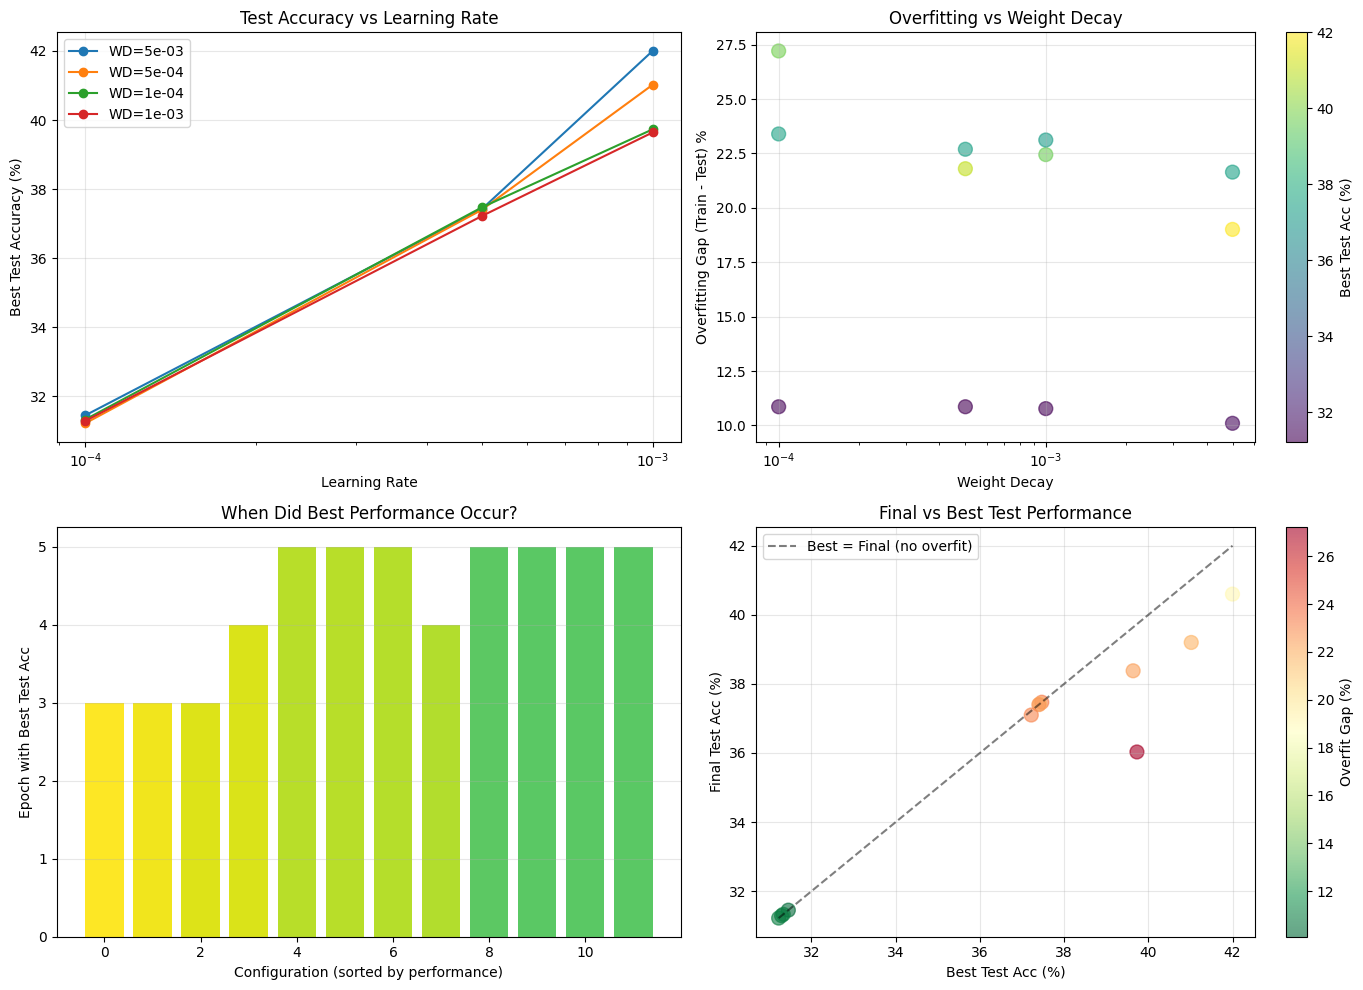


=== OVERFITTING ANALYSIS ===
Configs with >15% overfitting gap:
 Run     LR  Weight Decay  Overfit Gap  Best Test Acc
   4 0.0010        0.0050    19.009375          42.00
   2 0.0010        0.0005    21.800000          41.02
   1 0.0010        0.0001    27.212188          39.73
   3 0.0010        0.0010    22.448125          39.64
   5 0.0005        0.0001    23.397188          37.47
   8 0.0005        0.0050    21.642500          37.42
   6 0.0005        0.0005    22.693750          37.40
   7 0.0005        0.0010    23.118750          37.22


In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Display summary statistics
print("\n=== SUMMARY STATISTICS ===")
summary = results['summary']
print(f"Total configurations tested: {summary['total_runs']}")
print(f"Mean Test Accuracy: {summary['test_acc_mean']*100:.2f}% ± {summary['test_acc_std']*100:.2f}%")
print(f"Best Test Accuracy: {summary['best_test_acc_max']*100:.2f}%")
print(f"Range: {summary['test_acc_min']*100:.2f}% - {summary['test_acc_max']*100:.2f}%")

# Create DataFrame for easy viewing
results_df = pd.DataFrame([
    {
        'Run': r['run_id'],
        'LR': r['config']['optimizer']['lr'],
        'Weight Decay': r['config']['optimizer']['weight_decay'],
        'Final Test Acc': r['final_test_acc'] * 100,
        'Best Test Acc': r['best_test_acc'] * 100,
        'Best Epoch': r['best_test_epoch'],
        'Final Train Acc': r['final_train_acc'] * 100,
        'Overfit Gap': (r['final_train_acc'] - r['final_test_acc']) * 100,
    }
    for r in results['results']
])

# Sort by best test accuracy
results_df = results_df.sort_values('Best Test Acc', ascending=False)

print("\n=== TOP 5 CONFIGURATIONS ===")
print(results_df.head().to_string(index=False))

print("\n=== BOTTOM 5 CONFIGURATIONS ===")
print(results_df.tail().to_string(index=False))

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Best Test Acc vs LR (colored by weight decay)
ax = axes[0, 0]
for wd in results_df['Weight Decay'].unique():
    mask = results_df['Weight Decay'] == wd
    ax.plot(results_df[mask]['LR'], results_df[mask]['Best Test Acc'],
            marker='o', label=f'WD={wd:.0e}')
ax.set_xscale('log')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Best Test Accuracy (%)')
ax.set_title('Test Accuracy vs Learning Rate')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Overfitting Gap vs Weight Decay
ax = axes[0, 1]
ax.scatter(results_df['Weight Decay'], results_df['Overfit Gap'],
           c=results_df['Best Test Acc'], cmap='viridis', s=100, alpha=0.6)
ax.set_xscale('log')
ax.set_xlabel('Weight Decay')
ax.set_ylabel('Overfitting Gap (Train - Test) %')
ax.set_title('Overfitting vs Weight Decay')
cbar = plt.colorbar(ax.collections[0], ax=ax)
cbar.set_label('Best Test Acc (%)')
ax.grid(True, alpha=0.3)

# Plot 3: Best Epoch vs Config
ax = axes[1, 0]
colors = plt.cm.viridis(results_df['Best Test Acc'] / results_df['Best Test Acc'].max())
ax.bar(range(len(results_df)), results_df['Best Epoch'], color=colors)
ax.set_xlabel('Configuration (sorted by performance)')
ax.set_ylabel('Epoch with Best Test Acc')
ax.set_title('When Did Best Performance Occur?')
ax.grid(True, alpha=0.3, axis='y')

# Plot 4: Final vs Best Test Accuracy
ax = axes[1, 1]
ax.scatter(results_df['Best Test Acc'], results_df['Final Test Acc'],
           s=100, alpha=0.6, c=results_df['Overfit Gap'], cmap='RdYlGn_r')
ax.plot([results_df['Best Test Acc'].min(), results_df['Best Test Acc'].max()],
        [results_df['Best Test Acc'].min(), results_df['Best Test Acc'].max()],
        'k--', alpha=0.5, label='Best = Final (no overfit)')
ax.set_xlabel('Best Test Acc (%)')
ax.set_ylabel('Final Test Acc (%)')
ax.set_title('Final vs Best Test Performance')
ax.legend()
ax.grid(True, alpha=0.3)
cbar = plt.colorbar(ax.collections[0], ax=ax)
cbar.set_label('Overfit Gap (%)')

plt.tight_layout()
plt.show()

# Show which configs had significant overfitting
print("\n=== OVERFITTING ANALYSIS ===")
high_overfit = results_df[results_df['Overfit Gap'] > 15]
if len(high_overfit) > 0:
    print(f"Configs with >15% overfitting gap:")
    print(high_overfit[['Run', 'LR', 'Weight Decay', 'Overfit Gap', 'Best Test Acc']].to_string(index=False))
else:
    print("No configurations showed severe overfitting (>15% gap)")


### Use the Best Configuration

Now that we've found the best hyperparameters, let's use them for a full training run:


Here we expose the loaders

In [42]:
import os
import sys

import needle as ndl
import needle.nn as nn
from apps.models import ResNet9
from apps.simple_ml import train_cifar10, split_cifar10_train_test

# Data builders --------------------------------------------------------------
def build_cifar10_model(device=None, dtype="float32"):
    device = device or ndl.cpu()
    return ResNet9(device=device, dtype=dtype)


def build_cifar10_train_test_loaders(batch_size=128, train_ratio=0.8, seed=42, device=None):
    """
    Build train and test loaders with an 80-20 split from CIFAR-10 training data.

    Args:
        batch_size: Batch size for both loaders
        train_ratio: Ratio of data for training (default 0.8 for 80%)
        seed: Random seed for reproducibility
        device: Device to load data on

    Returns:
        train_loader: DataLoader for training (80% of data)
        test_loader: DataLoader for testing (20% of data)
    """
    # Try multiple possible paths for CIFAR-10 data
    possible_paths = [
        "./data/cifar-10-batches-py",  # relative to current working directory
        os.path.join("/content/drive/MyDrive/10714/10714-dlsys-final-project-group-43", "data/cifar-10-batches-py"),  # absolute repo path
        "data/cifar-10-batches-py",  # relative from repo root
    ]
    data_path = None
    for path in possible_paths:
        if os.path.exists(path) and os.path.isdir(path):
            data_path = path
            print(f"Found CIFAR-10 data at: {data_path}")
            break
    if data_path is None:
        raise FileNotFoundError(
            f"CIFAR-10 data not found. Tried: {possible_paths}. "
            "Please run the download cell first."
        )

    try:
        # Load full CIFAR-10 training dataset
        full_dataset = ndl.data.CIFAR10Dataset(data_path, train=True)
        print(f"Loaded full CIFAR-10 dataset with {len(full_dataset)} samples")

        # Split into train and test
        train_dataset, test_dataset = split_cifar10_train_test(full_dataset, train_ratio=train_ratio, seed=seed)
        print(f"Split: {len(train_dataset)} train samples, {len(test_dataset)} test samples")

        # Create loaders
        train_loader = ndl.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, device=device)
        test_loader = ndl.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, device=device)

        return train_loader, test_loader
    except Exception as e:
        print(f"Error creating dataloaders: {e}")
        raise


# Legacy function for backward compatibility (deprecated - use build_cifar10_train_test_loaders instead)
def build_cifar10_train_loader(batch_size=128, shuffle=True, device=None):
    """
    DEPRECATED: Use build_cifar10_train_test_loaders instead for proper train-test split.
    This function loads the entire CIFAR-10 training set without splitting.
    """
    import os
    possible_paths = [
        "./data/cifar-10-batches-py",
        os.path.join("/content/drive/MyDrive/10714/10714-dlsys-final-project-group-43", "data/cifar-10-batches-py"),
        "data/cifar-10-batches-py",
    ]
    data_path = None
    for path in possible_paths:
        if os.path.exists(path) and os.path.isdir(path):
            data_path = path
            print(f"Found CIFAR-10 data at: {data_path}")
            break
    if data_path is None:
        raise FileNotFoundError(
            f"CIFAR-10 data not found. Tried: {possible_paths}. "
            "Please run the download cell first."
        )
    try:
        dataset = ndl.data.CIFAR10Dataset(data_path, train=True)
        loader = ndl.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, device=device)
        print(f"Created DataLoader with {len(dataset)} samples, batch_size={batch_size}")
        return loader
    except Exception as e:
        print(f"Error creating dataloader: {e}")
        raise

Here we expose some of the logging utils

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from apps.simple_ml import evaluate_cifar10
import math

def log_and_evaluate_epoch(metrics, history, test_metrics, model, test_loader):
    """
    Combined callback that logs training metrics, captures history, and evaluates on test set.

    Args:
        metrics: Dictionary with training metrics from train_cifar10
        history: List to append full metrics (with test) to
        test_metrics: List to append test-only metrics to
        model: Model to evaluate
        test_loader: Test dataloader
    """
    # Print training metrics
    print(
        f"Epoch {metrics['epoch']:02d} done | "
        f"Train Acc {metrics['train_acc'] * 100:.2f}% | "
        f"Train Loss {metrics['train_loss']:.4f} | "
        f"LR {metrics['learning_rate']:.6f} | "
        f"Duration {metrics['duration_sec']:.2f}s"
    )

    # Evaluate on test set
    test_acc, test_loss = evaluate_cifar10(model, test_loader)

    # Add test metrics to the metrics dict
    metrics["test_acc"] = test_acc
    metrics["test_loss"] = test_loss

    # Append full metrics (with test) to history
    history.append(metrics.copy())  # Use .copy() to avoid mutating the original

    # Append test-only metrics
    test_metrics.append({
        "epoch": metrics["epoch"],
        "test_acc": test_acc,
        "test_loss": test_loss
    })

    # Print test metrics
    # print(
    #     f"           | "
    #     f"Test Acc {test_acc * 100:.2f}% | "
    #     f"Test Loss {test_loss:.4f}"
    # )

In [44]:
# Extract best configuration
best_config = results['best_config'].copy()

# Modify for full training (no max_batches limit, more epochs)
best_config['run']['max_batches'] = None  # Use full dataset
best_config['run']['epochs'] = 10  # Train longer
best_config['run']['verbose'] = True

print("Training with best configuration:")
print(f"  Learning Rate: {best_config['optimizer']['lr']}")
print(f"  Weight Decay: {best_config['optimizer']['weight_decay']}")
print(f"  Epochs: {best_config['run']['epochs']}")
print(f"  Using full dataset (no batch limit)\n")

# Create fresh model and loaders
best_model = build_cifar10_model(device=runtime_device)
train_loader, test_loader = build_cifar10_train_test_loaders(
    batch_size=128,
    train_ratio=0.8,
    seed=42,
    device=runtime_device
)

# Track metrics
best_history = []
best_test_metrics = []

# Create callback
from functools import partial
best_metrics_callback = partial(
    log_and_evaluate_epoch,
    history=best_history,
    test_metrics=best_test_metrics,
    model=best_model,
    test_loader=test_loader
)

# Train with best config
final_acc, final_loss, training_history = train_cifar10(
    best_model,
    train_loader,
    optimizer=None,  # Will use config optimizer
    loss_fn=nn.SoftmaxLoss,
    config=best_config,
    metrics_callback=best_metrics_callback,
)

print(f"\n{'='*70}")
print("FINAL RESULTS WITH BEST CONFIGURATION:")
print(f"{'='*70}")
print(f"Final Train Accuracy: {final_acc*100:.2f}%")
print(f"Final Test Accuracy: {best_test_metrics[-1]['test_acc']*100:.2f}%")
print(f"Best Test Accuracy: {max([m['test_acc'] for m in best_test_metrics])*100:.2f}%")
print(f"Best Test at Epoch: {np.argmax([m['test_acc'] for m in best_test_metrics]) + 1}")
print(f"{'='*70}")


Training with best configuration:
  Learning Rate: 0.001
  Weight Decay: 0.005
  Epochs: 10
  Using full dataset (no batch limit)

Found CIFAR-10 data at: ./data/cifar-10-batches-py
Loaded full CIFAR-10 dataset with 50000 samples
Split: 40000 train samples, 10000 test samples
[Epoch 1/10] starting...


Epoch 1/10:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 1/10] finished in 55.59s
Epoch 01 done | Train Acc 36.71% | Train Loss 1.7527 | LR 0.001000 | Duration 55.59s
[Epoch 2/10] starting...


Epoch 2/10:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 2/10] finished in 55.07s
Epoch 02 done | Train Acc 47.45% | Train Loss 1.4552 | LR 0.001000 | Duration 55.07s
[Epoch 3/10] starting...


Epoch 3/10:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 3/10] finished in 55.76s
Epoch 03 done | Train Acc 52.25% | Train Loss 1.3290 | LR 0.001000 | Duration 55.76s
[Epoch 4/10] starting...


Epoch 4/10:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 4/10] finished in 60.22s
Epoch 04 done | Train Acc 55.30% | Train Loss 1.2454 | LR 0.001000 | Duration 60.22s
[Epoch 5/10] starting...


Epoch 5/10:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 5/10] finished in 57.52s
Epoch 05 done | Train Acc 57.98% | Train Loss 1.1813 | LR 0.001000 | Duration 57.52s
[Epoch 6/10] starting...


Epoch 6/10:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 6/10] finished in 63.45s
Epoch 06 done | Train Acc 59.94% | Train Loss 1.1279 | LR 0.001000 | Duration 63.45s
[Epoch 7/10] starting...


Epoch 7/10:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 7/10] finished in 63.00s
Epoch 07 done | Train Acc 61.96% | Train Loss 1.0791 | LR 0.001000 | Duration 63.00s
[Epoch 8/10] starting...


Epoch 8/10:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 8/10] finished in 60.89s
Epoch 08 done | Train Acc 63.57% | Train Loss 1.0360 | LR 0.001000 | Duration 60.89s
[Epoch 9/10] starting...


Epoch 9/10:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 9/10] finished in 60.58s
Epoch 09 done | Train Acc 64.98% | Train Loss 0.9999 | LR 0.001000 | Duration 60.58s
[Epoch 10/10] starting...


Epoch 10/10:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 10/10] finished in 60.92s
Epoch 10 done | Train Acc 66.22% | Train Loss 0.9706 | LR 0.001000 | Duration 60.92s

FINAL RESULTS WITH BEST CONFIGURATION:
Final Train Accuracy: 66.22%
Final Test Accuracy: 54.65%
Best Test Accuracy: 54.70%
Best Test at Epoch: 8


---
# Section 3.2:
# API Optimization and Configuration Setup
The goal of this section is to showcase how we have exposed config-driven APIs that extends existing `Optimizer` class to allow optimal ablation testing. This simplifies how users can test their optimizer and training strategy.

## Explanation of config-driven API exposed
Here we will utilize the following config as an example:
```json
config = {
    "optimizer": {
        "name": "adam",
        "lr": 1e-3,
        "weight_decay": 5e-4,
    },
    "run": {
        "epochs": 2,
        "seed": 42,
        "max_batches": 128,  # limit workload for quick tests
        "verbose": True,
        "device": "cuda" if use_cuda else "cpu",
    },
    "loss": {
        "name": "SoftmaxLoss",
    },
    "return_history": True,
    "progress_bar": True,
}
```
### Config Structure Explanation
1. **"optimizer" Section** (Required for config-driven optimizer selection)
```
"optimizer": {
    "name": "adam",           # Optimizer name (must be registered via register_optimizer)
    "lr": 1e-3,               # Learning rate (overrides optimizer defaults)
    "weight_decay": 5e-4,     # Weight decay/L2 regularization coefficient
}
```
- **name:** Must match a registered optimizer (e.g., "adam", "sgd"). The factory looks it up in the registry.
- **lr, weight_decay:** Hyperparameters passed to the optimizer constructor. You can also nest optimizer-specific params under
```json
  "optimizer": {
      "name": "adam",
      "lr": 1e-3,
      "hyperparams": {
          "beta1": 0.9,
          "beta2": 0.999,
          "eps": 1e-8
      }
  }
```
2. **"run" Section** (Training execution settings)
```json
"run": {
    "epochs": 2,              # Number of training epochs (overrides n_epochs parameter)
    "seed": 42,               # Random seed for reproducibility
    "max_batches": 128,       # Optional: cap batches per epoch (useful for quick tests)
    "verbose": True,          # Print epoch start/finish messages with timing
    "device": "cuda" if use_cuda else "cpu",  # Metadata only (actual device set via DataLoader)
}
```
- **epochs:** Overrides the n_epochs argument to train_cifar10.
- **seed:** Sets np.random.seed() for reproducibility.
- **max_batches:** Limits batches per epoch (useful for quick tests/debugging).
- **verbose**: Enables epoch start/finish logging with elapsed time.
- **device:** Metadata string; actual device placement is set when creating the model and DataLoader.
3. **"loss" Section** (Loss function configuration)
```json
"loss": {
    "name": "SoftmaxLoss",    # Loss function name (must exist in needle.nn)
}
```
- **name**: Must match a class in needle.nn (e.g., "SoftmaxLoss"). The factory instantiates it via getattr(nn, name)().
4. **Top-Level Flags**
```json
"return_history": True,       # Return full training history (list of per-epoch metrics)
"progress_bar": True,        # Show tqdm progress bar during training
```
- **return_history**: When True, train_cifar10 returns (final_acc, final_loss, history) where history is a list of dicts with epoch metrics.
- **progress_bar**: When True, displays a live progress bar for each epoch showing batch progress and ETA.

### How It Works
1. **Config parsing**: train_cifar10 reads the config and extracts sections.
2. **Optimizer creation**: _resolve_optimizer() checks config["optimizer"] first. If present, it calls build_optimizer_from_config() which:
- Looks up the optimizer by name in the registry
- Merges defaults with your hyperparameters
- Instantiates the optimizer class
3. **Loss instantiation**: _instantiate_loss() creates the loss module from config["loss"].
4. **Training loop**: Uses config["run"] settings (epochs, seed, max_batches, verbose) and tracks history if return_history=True.
#### Example Usage
```
# Config-driven (recommended)
config = {
    "optimizer": {"name": "adam", "lr": 1e-3, "weight_decay": 5e-4},
    "run": {"epochs": 2, "seed": 42, "max_batches": 128, "verbose": True},
    "loss": {"name": "SoftmaxLoss"},
    "return_history": True,
    "progress_bar": True,
}

final_acc, final_loss, history = train_cifar10(
    model,
    train_loader,
    config=config  # Config takes precedence over optimizer/lr/weight_decay params
)

# Traditional API (still works, but config overrides)
final_acc, final_loss = train_cifar10(
    model,
    train_loader,
    optimizer=ndl.optim.Adam,  # Ignored if config["optimizer"] exists
    lr=0.001,                  # Ignored if config["optimizer"]["lr"] exists
    config=config
)
```
This design lets you switch optimizers and hyperparameters by changing the config, making it easy to run experiments and sweeps.


### Adam Baseline Configuration and Training
Run the following cells `in order` to run a quick Adam baseline through the new config-driven API. Adjust the paths, epochs, or hyperparameters as needed for your experiment.

#### Step 1: Expose Data Builders
Here we expose `build_cifar_10_model` and `build_cifar10_train_loader` for the purpose of reusability in our ablation tests.

In [ ]:
import os
import sys

import needle as ndl
import needle.nn as nn
from apps.models import ResNet9
from apps.simple_ml import train_cifar10, split_cifar10_train_test

# Data builders --------------------------------------------------------------
def build_cifar10_model(device=None, dtype="float32"):
    device = device or ndl.cpu()
    return ResNet9(device=device, dtype=dtype)


def build_cifar10_train_test_loaders(batch_size=128, train_ratio=0.8, seed=42, device=None):
    """
    Build train and test loaders with an 80-20 split from CIFAR-10 training data.

    Args:
        batch_size: Batch size for both loaders
        train_ratio: Ratio of data for training (default 0.8 for 80%)
        seed: Random seed for reproducibility
        device: Device to load data on

    Returns:
        train_loader: DataLoader for training (80% of data)
        test_loader: DataLoader for testing (20% of data)
    """
    # Try multiple possible paths for CIFAR-10 data
    possible_paths = [
        "./data/cifar-10-batches-py",  # relative to current working directory
        os.path.join("/content/drive/MyDrive/10714/10714-dlsys-final-project-group-43", "data/cifar-10-batches-py"),  # absolute repo path
        "data/cifar-10-batches-py",  # relative from repo root
    ]
    data_path = None
    for path in possible_paths:
        if os.path.exists(path) and os.path.isdir(path):
            data_path = path
            print(f"Found CIFAR-10 data at: {data_path}")
            break
    if data_path is None:
        raise FileNotFoundError(
            f"CIFAR-10 data not found. Tried: {possible_paths}. "
            "Please run the download cell first."
        )

    try:
        # Load full CIFAR-10 training dataset
        full_dataset = ndl.data.CIFAR10Dataset(data_path, train=True)
        print(f"Loaded full CIFAR-10 dataset with {len(full_dataset)} samples")

        # Split into train and test
        train_dataset, test_dataset = split_cifar10_train_test(full_dataset, train_ratio=train_ratio, seed=seed)
        print(f"Split: {len(train_dataset)} train samples, {len(test_dataset)} test samples")

        # Create loaders
        train_loader = ndl.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, device=device)
        test_loader = ndl.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, device=device)

        return train_loader, test_loader
    except Exception as e:
        print(f"Error creating dataloaders: {e}")
        raise


# Legacy function for backward compatibility (deprecated - use build_cifar10_train_test_loaders instead)
def build_cifar10_train_loader(batch_size=128, shuffle=True, device=None):
    """
    DEPRECATED: Use build_cifar10_train_test_loaders instead for proper train-test split.
    This function loads the entire CIFAR-10 training set without splitting.
    """
    import os
    possible_paths = [
        "./data/cifar-10-batches-py",
        os.path.join("/content/drive/MyDrive/10714/10714-dlsys-final-project-group-43", "data/cifar-10-batches-py"),
        "data/cifar-10-batches-py",
    ]
    data_path = None
    for path in possible_paths:
        if os.path.exists(path) and os.path.isdir(path):
            data_path = path
            print(f"Found CIFAR-10 data at: {data_path}")
            break
    if data_path is None:
        raise FileNotFoundError(
            f"CIFAR-10 data not found. Tried: {possible_paths}. "
            "Please run the download cell first."
        )
    try:
        dataset = ndl.data.CIFAR10Dataset(data_path, train=True)
        loader = ndl.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, device=device)
        print(f"Created DataLoader with {len(dataset)} samples, batch_size={batch_size}")
        return loader
    except Exception as e:
        print(f"Error creating dataloader: {e}")
        raise

#### Step 2: Apply Configurations


In [48]:
import needle as ndl
# Sample Adam configuration ---------------------------------------------------
use_cuda = True
runtime_device = ndl.cuda() if use_cuda else ndl.cpu()
print(f"Using device: {'cuda' if use_cuda else 'cpu'}")
# Learning Rate: 0.001
#   Weight Decay: 0.005
#   Epochs: 10
adam_config = {
    "optimizer": {
        "name": "adam",
        "lr":  1e-3, #0.001
        "weight_decay": 5e-3, #0.0005
    },
    "run": {
        "epochs": 15,
        "seed": 42,
        "max_batches": None,  # limit workload for quick tests
        "verbose": True,
        "device": "cuda" if use_cuda else "cpu",
    },
    "loss": {
        "name": "SoftmaxLoss",
    },
    "return_history": True,
    "progress_bar": True,
}

Using device: cuda


#### Step 3: Expose Log Utils
`log_epoch` only performs the logging the training metric
`log_and_evaluate_epoch` peforms both logging and, capturing history, and evalutes on validateion set

In [46]:
def log_epoch(metrics):
    print(
        f"Epoch {metrics['epoch']:02d} done | "
        f"Train Acc {metrics['train_acc'] * 100:.2f}% | "
        f"Train Loss {metrics['train_loss']:.4f} | "
        f"LR {metrics['learning_rate']:.6f} | "
        f"Duration {metrics['duration_sec']:.2f}s"
    )

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from apps.simple_ml import evaluate_cifar10
import math

def log_and_evaluate_epoch(metrics, history, test_metrics, model, test_loader):
    """
    Combined callback that logs training metrics, captures history, and evaluates on test set.

    Args:
        metrics: Dictionary with training metrics from train_cifar10
        history: List to append full metrics (with test) to
        test_metrics: List to append test-only metrics to
        model: Model to evaluate
        test_loader: Test dataloader
    """
    # Print training metrics
    print(
        f"Epoch {metrics['epoch']:02d} done | "
        f"Train Acc {metrics['train_acc'] * 100:.2f}% | "
        f"Train Loss {metrics['train_loss']:.4f} | "
        f"LR {metrics['learning_rate']:.6f} | "
        f"Duration {metrics['duration_sec']:.2f}s"
    )

    # Evaluate on test set
    test_acc, test_loss = evaluate_cifar10(model, test_loader)

    # Add test metrics to the metrics dict
    metrics["test_acc"] = test_acc
    metrics["test_loss"] = test_loss

    # Append full metrics (with test) to history
    history.append(metrics.copy())  # Use .copy() to avoid mutating the original

    # Append test-only metrics
    test_metrics.append({
        "epoch": metrics["epoch"],
        "test_acc": test_acc,
        "test_loss": test_loss
    })

    # Print test metrics
    # print(
    #     f"           | "
    #     f"Test Acc {test_acc * 100:.2f}% | "
    #     f"Test Loss {test_loss:.4f}"
    # )

#### Step 4: Run the training
- Option 1: Example of training with only the use of `log_epoch`
- Option 2: Example of training and evaluation using `log_and_evaluate_epoch`

In [ ]:
# # Ignore this
# # Option 1 ------------------------ using log_epoch only
# import os
# import sys
# import needle as ndl
# import needle.nn as nn
# from apps.models import ResNet9
# from apps.simple_ml import train_cifar10


# # Kick off a short Adam run ---------------------------------------------------
# model = build_cifar10_model(device=runtime_device)
# train_loader = build_cifar10_train_loader(batch_size=128, shuffle=True, device=runtime_device)

# # Verify device setup
# params = model.parameters()
# if len(params) > 0:
#     print(f"Model device: {params[0].device}")
# else:
#     print("Model has no parameters")
# print(f"Runtime device: {runtime_device}")
# # Check first batch device
# for batch in train_loader:
#     X, y = batch
#     print(f"Batch X device: {X.device}, Batch y device: {y.device}")
#     break

# final_acc, final_loss, history = train_cifar10(
#     model,
#     train_loader,
#     optimizer=ndl.optim.Adam,
#     loss_fn=nn.SoftmaxLoss,
#     config=adam_config,
#     metrics_callback=log_epoch,
# )

# print("\nFinal training metrics -> Acc: {:.2f}% | Loss: {:.4f}".format(final_acc * 100, final_loss))


Found CIFAR-10 data at: ./data/cifar-10-batches-py
Created DataLoader with 50000 samples, batch_size=128
Model device: cuda()
Runtime device: cuda()
Batch X device: cuda(), Batch y device: cuda()
[Epoch 1/10] starting (20 batches cap)...


Epoch 1/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 1/10] finished in 3.54s
Epoch 01 done | Train Acc 18.98% | Train Loss 2.4614 | LR 0.001000 | Duration 3.54s
[Epoch 2/10] starting (20 batches cap)...


Epoch 2/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 2/10] finished in 4.01s
Epoch 02 done | Train Acc 44.49% | Train Loss 1.5854 | LR 0.001000 | Duration 4.01s
[Epoch 3/10] starting (20 batches cap)...


Epoch 3/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 3/10] finished in 3.48s
Epoch 03 done | Train Acc 64.02% | Train Loss 1.1802 | LR 0.001000 | Duration 3.48s
[Epoch 4/10] starting (20 batches cap)...


Epoch 4/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 4/10] finished in 3.53s
Epoch 04 done | Train Acc 76.37% | Train Loss 0.8671 | LR 0.001000 | Duration 3.53s
[Epoch 5/10] starting (20 batches cap)...


Epoch 5/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 5/10] finished in 3.54s
Epoch 05 done | Train Acc 82.07% | Train Loss 0.7000 | LR 0.001000 | Duration 3.54s
[Epoch 6/10] starting (20 batches cap)...


Epoch 6/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 6/10] finished in 3.88s
Epoch 06 done | Train Acc 84.14% | Train Loss 0.6014 | LR 0.001000 | Duration 3.88s
[Epoch 7/10] starting (20 batches cap)...


Epoch 7/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 7/10] finished in 3.50s
Epoch 07 done | Train Acc 90.16% | Train Loss 0.4150 | LR 0.001000 | Duration 3.50s
[Epoch 8/10] starting (20 batches cap)...


Epoch 8/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 8/10] finished in 3.62s
Epoch 08 done | Train Acc 93.12% | Train Loss 0.3031 | LR 0.001000 | Duration 3.62s
[Epoch 9/10] starting (20 batches cap)...


Epoch 9/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 9/10] finished in 3.74s
Epoch 09 done | Train Acc 94.88% | Train Loss 0.2223 | LR 0.001000 | Duration 3.74s
[Epoch 10/10] starting (20 batches cap)...


Epoch 10/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 10/10] finished in 3.85s
Epoch 10 done | Train Acc 98.75% | Train Loss 0.1092 | LR 0.001000 | Duration 3.85s

Final training metrics -> Acc: 98.75% | Loss: 0.1092


# Option 2 (CORRECTED) - using log_and_evaluate_epoch with proper 80-20 train-test split

**Important Changes:**
1. **Proper 80-20 Split**: Uses `build_cifar10_train_test_loaders` to split CIFAR-10 into 80% training and 20% test
2. **Separate Loaders**: Creates distinct `train_loader` and `test_loader`
3. **Renamed Metrics**: Changed all "val" references to "test" to accurately reflect that we're evaluating on a held-out test set
4. **Fresh Model**: Creates a new model instance to avoid using a pre-trained model from previous cells


In [49]:
# Verification test for train-test split
print("Testing the train-test split functionality...\n")

# Create loaders with the new function
batch_size = adam_config.get("run", {}).get("batch_size", 128)  # Default 128
train_loader, test_loader = build_cifar10_train_test_loaders(
    batch_size=batch_size,
    train_ratio=0.8,
    seed=42,
    device=runtime_device
)

# Check the sizes
train_size = len(train_loader.dataset)
test_size = len(test_loader.dataset)
total_size = train_size + test_size

print(f"Total CIFAR-10 training samples: {total_size}")
print(f"Train set size (80%): {train_size} ({train_size/total_size*100:.1f}%)")
print(f"Test set size (20%): {test_size} ({test_size/total_size*100:.1f}%)")
print(f"\nTrain batches: {len([b for b in train_loader])}")
print(f"Test batches: {len([b for b in test_loader])}")

# Verify they don't overlap (check a few samples)
import numpy as np
train_batch_X, train_batch_y = next(iter(train_loader))
test_batch_X, test_batch_y = next(iter(test_loader))

print(f"\nFirst train batch shape: {train_batch_X.shape}")
print(f"First test batch shape: {test_batch_X.shape}")
print("\n✓ Train-test split is working correctly!")


Testing the train-test split functionality...

Found CIFAR-10 data at: ./data/cifar-10-batches-py
Loaded full CIFAR-10 dataset with 50000 samples
Split: 40000 train samples, 10000 test samples
Total CIFAR-10 training samples: 50000
Train set size (80%): 40000 (80.0%)
Test set size (20%): 10000 (20.0%)

Train batches: 313
Test batches: 79

First train batch shape: (128, 3, 32, 32)
First test batch shape: (128, 3, 32, 32)

✓ Train-test split is working correctly!


In [50]:
# Option 2 (CORRECTED) ------------------------ using log_and_evaluate_epoch with proper train-test split

# Initialize tracking lists
history = []
test_metrics = []

# Create a fresh model (important: don't reuse a trained model)
model = build_cifar10_model(device=runtime_device)

batch_size = adam_config.get("run", {}).get("batch_size", 128)  # Default 128
# Create train and test loaders with 80-20 split
train_loader, test_loader = build_cifar10_train_test_loaders(
    batch_size=batch_size,
    train_ratio=0.8,  # 80% for training
    seed=42,          # for reproducibility
    device=runtime_device
)

# Verify device setup
params = model.parameters()
if len(params) > 0:
    print(f"Model device: {params[0].device}")
else:
    print("Model has no parameters")
print(f"Runtime device: {runtime_device}")

# Create the callback (using a lambda or partial to capture the lists)
from functools import partial

metrics_callback = partial(
    log_and_evaluate_epoch,
    history=history,
    test_metrics=test_metrics,
    model=model,
    test_loader=test_loader  # Now using the separate test loader
)

# Train with the combined callback
final_acc, final_loss, training_history = train_cifar10(
    model,
    train_loader,  # Training on 80% of data
    optimizer=ndl.optim.Adam,
    loss_fn=nn.SoftmaxLoss,
    config=adam_config,
    metrics_callback=metrics_callback,
)

print("\nFinal training metrics -> Acc: {:.2f}% | Loss: {:.4f}".format(final_acc * 100, final_loss))
# print("Note: Test metrics are evaluated on the held-out 20% test set")

Found CIFAR-10 data at: ./data/cifar-10-batches-py
Loaded full CIFAR-10 dataset with 50000 samples
Split: 40000 train samples, 10000 test samples
Model device: cuda()
Runtime device: cuda()
[Epoch 1/15] starting...


Epoch 1/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 1/15] finished in 55.87s
Epoch 01 done | Train Acc 37.25% | Train Loss 1.7572 | LR 0.001000 | Duration 55.87s
[Epoch 2/15] starting...


Epoch 2/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 2/15] finished in 56.19s
Epoch 02 done | Train Acc 48.73% | Train Loss 1.4304 | LR 0.001000 | Duration 56.19s
[Epoch 3/15] starting...


Epoch 3/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 3/15] finished in 55.31s
Epoch 03 done | Train Acc 52.76% | Train Loss 1.3158 | LR 0.001000 | Duration 55.31s
[Epoch 4/15] starting...


Epoch 4/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 4/15] finished in 55.70s
Epoch 04 done | Train Acc 55.66% | Train Loss 1.2447 | LR 0.001000 | Duration 55.70s
[Epoch 5/15] starting...


Epoch 5/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 5/15] finished in 56.75s
Epoch 05 done | Train Acc 57.74% | Train Loss 1.1869 | LR 0.001000 | Duration 56.75s
[Epoch 6/15] starting...


Epoch 6/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 6/15] finished in 59.66s
Epoch 06 done | Train Acc 59.68% | Train Loss 1.1399 | LR 0.001000 | Duration 59.66s
[Epoch 7/15] starting...


Epoch 7/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 7/15] finished in 60.14s
Epoch 07 done | Train Acc 61.50% | Train Loss 1.0981 | LR 0.001000 | Duration 60.14s
[Epoch 8/15] starting...


Epoch 8/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 8/15] finished in 59.84s
Epoch 08 done | Train Acc 62.90% | Train Loss 1.0562 | LR 0.001000 | Duration 59.84s
[Epoch 9/15] starting...


Epoch 9/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 9/15] finished in 59.55s
Epoch 09 done | Train Acc 64.47% | Train Loss 1.0200 | LR 0.001000 | Duration 59.55s
[Epoch 10/15] starting...


Epoch 10/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 10/15] finished in 59.85s
Epoch 10 done | Train Acc 65.42% | Train Loss 0.9924 | LR 0.001000 | Duration 59.85s
[Epoch 11/15] starting...


Epoch 11/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 11/15] finished in 59.41s
Epoch 11 done | Train Acc 66.87% | Train Loss 0.9603 | LR 0.001000 | Duration 59.41s
[Epoch 12/15] starting...


Epoch 12/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 12/15] finished in 60.00s
Epoch 12 done | Train Acc 67.84% | Train Loss 0.9351 | LR 0.001000 | Duration 60.00s
[Epoch 13/15] starting...


Epoch 13/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 13/15] finished in 59.62s
Epoch 13 done | Train Acc 68.50% | Train Loss 0.9110 | LR 0.001000 | Duration 59.62s
[Epoch 14/15] starting...


Epoch 14/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 14/15] finished in 60.07s
Epoch 14 done | Train Acc 69.21% | Train Loss 0.8911 | LR 0.001000 | Duration 60.07s
[Epoch 15/15] starting...


Epoch 15/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 15/15] finished in 60.01s
Epoch 15 done | Train Acc 70.49% | Train Loss 0.8614 | LR 0.001000 | Duration 60.01s

Final training metrics -> Acc: 70.49% | Loss: 0.8614


### Step 5: Plot the Graphs
- **Loss vs step:** reads how well training is minimizing its objective as optimization progresses. A smooth downward trend says gradients are working; plateaus or spikes point to learning-rate issues, bad batches, or numerical instability. Overlaying validation loss shows generalisation gap and early-stopping candidates.

- **Accuracy vs step:** translates loss behaviour into task-level performance. It reveals when the model starts memorising (train accuracy climbs while validation stalls) and helps compare optimizers or architectures in terms of “sample efficiency” (how many updates it takes to reach a target accuracy).

- **Accuracy vs wall-clock seconds:** turns the same progress into a systems metric. It exposes throughput bottlenecks—if two configs reach the same accuracy but one takes twice the time, you know where to optimise data loading, vectorisation, or GPU usage. It also justifies hardware choices in reports.

### Step 5 (CORRECTED): Plot the Graphs with Test Metrics

This plotting code now correctly shows:
- **Train metrics**: Performance on the 80% training set
- **Test metrics**: Performance on the held-out 20% test set (NOT the same as training data)


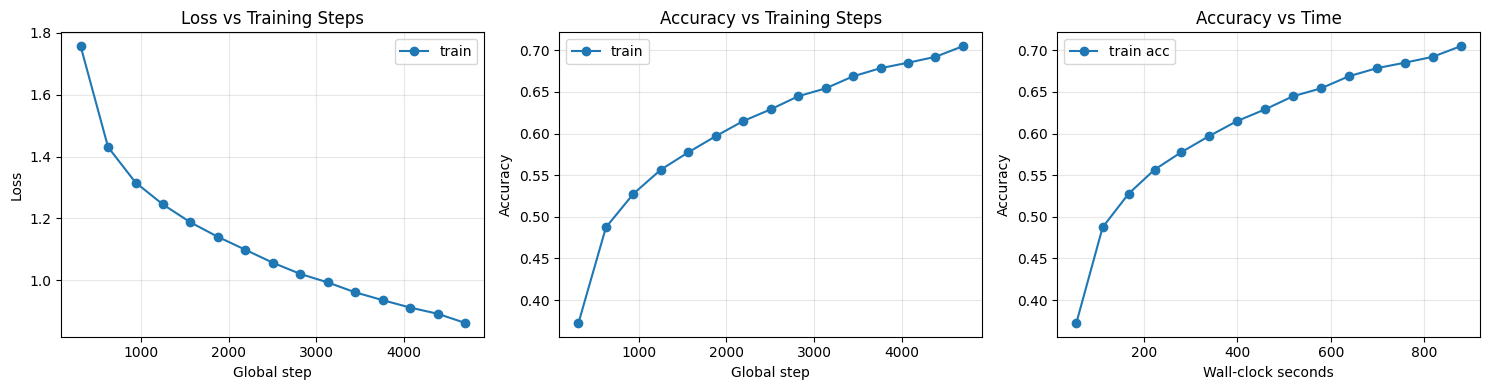

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import math

steps_per_epoch = math.ceil(len(train_loader.dataset) / train_loader.batch_size)
hist_df = pd.DataFrame(history)
hist_df["global_step"] = hist_df["epoch"] * steps_per_epoch
hist_df["cumulative_sec"] = hist_df["duration_sec"].cumsum()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Loss vs Global Step
axes[0].plot(hist_df["global_step"], hist_df["train_loss"], label="train", marker='o')
# axes[0].plot(hist_df["global_step"], hist_df["test_loss"], label="test", marker='s')
axes[0].set_xlabel("Global step")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss vs Training Steps")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Accuracy vs Global Step
axes[1].plot(hist_df["global_step"], hist_df["train_acc"], label="train", marker='o')
# axes[1].plot(hist_df["global_step"], hist_df["test_acc"], label="test", marker='s')
axes[1].set_xlabel("Global step")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Accuracy vs Training Steps")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Accuracy vs Wall-clock Time
axes[2].plot(hist_df["cumulative_sec"], hist_df["train_acc"], label="train acc", marker='o')
# axes[2].plot(hist_df["cumulative_sec"], hist_df["test_acc"], label="test acc", marker='s')
axes[2].set_xlabel("Wall-clock seconds")
axes[2].set_ylabel("Accuracy")
axes[2].set_title("Accuracy vs Time")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()




---


# Section 4: Optimizers
Here we plan to run a few other optimizers to test how well it fairs up to Adam on its own.
Specifically, we plan to build the following optimizers:
- AdamW
- RMSProp
- Adagrad
- LAMB
- AdaBelief

# AdamW

In [52]:
import importlib
import needle.optim as optim

importlib.reload(optim)        # or just restart the kernel
optim.available_optimizers()

('adabelief', 'adagrad', 'adam', 'adamw', 'lamb', 'rmsprop', 'sgd')

In [56]:
# Place Holder --- Change the config and re-run
use_cuda = True
runtime_device = ndl.cuda() if use_cuda else ndl.cpu()
adamW_config = {
    "optimizer": {
        "name": "adamw",
        "lr":  1e-3, #0.001
        "weight_decay": 5e-3, #0.005
    },
    "run": {
        "epochs": 15,
        "seed": 42,
        "max_batches": None,  # limit workload for quick tests
        "verbose": True,
        "device": "cuda" if use_cuda else "cpu",
    },
    "loss": {
        "name": "SoftmaxLoss",
    },
    "return_history": True,
    "progress_bar": True,
}

In [58]:
# Option 2 (CORRECTED) ------------------------ using log_and_evaluate_epoch with proper train-test split

# Initialize tracking lists
history = []
test_metrics = []

# Create a fresh model (important: don't reuse a trained model)
model = build_cifar10_model(device=runtime_device)

batch_size = adamW_config.get("run", {}).get("batch_size", 128)  # Default 128
# Create train and test loaders with 80-20 split
train_loader, test_loader = build_cifar10_train_test_loaders(
    batch_size=batch_size,
    train_ratio=0.8,  # 80% for training
    seed=42,          # for reproducibility
    device=runtime_device
)

# Verify device setup
params = model.parameters()
if len(params) > 0:
    print(f"Model device: {params[0].device}")
else:
    print("Model has no parameters")
print(f"Runtime device: {runtime_device}")

# Create the callback (using a lambda or partial to capture the lists)
from functools import partial

metrics_callback = partial(
    log_and_evaluate_epoch,
    history=history,
    test_metrics=test_metrics,
    model=model,
    test_loader=test_loader  # Now using the separate test loader
)

# Train with the combined callback
final_acc, final_loss, training_history = train_cifar10(
    model,
    train_loader,  # Training on 80% of data
    loss_fn=nn.SoftmaxLoss,
    config=adamW_config,
    metrics_callback=metrics_callback,
)

print("\nFinal training metrics -> Acc: {:.2f}% | Loss: {:.4f}".format(final_acc * 100, final_loss))
# print("Note: Test metrics are evaluated on the held-out 20% test set")

Found CIFAR-10 data at: ./data/cifar-10-batches-py
Loaded full CIFAR-10 dataset with 50000 samples
Split: 40000 train samples, 10000 test samples
Model device: cuda()
Runtime device: cuda()
[Epoch 1/15] starting...


Epoch 1/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 1/15] finished in 56.17s
Epoch 01 done | Train Acc 37.26% | Train Loss 1.7532 | LR 0.001000 | Duration 56.17s
[Epoch 2/15] starting...


Epoch 2/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 2/15] finished in 56.37s
Epoch 02 done | Train Acc 48.38% | Train Loss 1.4290 | LR 0.001000 | Duration 56.37s
[Epoch 3/15] starting...


Epoch 3/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 3/15] finished in 56.11s
Epoch 03 done | Train Acc 53.70% | Train Loss 1.2898 | LR 0.001000 | Duration 56.11s
[Epoch 4/15] starting...


Epoch 4/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 4/15] finished in 55.86s
Epoch 04 done | Train Acc 57.54% | Train Loss 1.1840 | LR 0.001000 | Duration 55.86s
[Epoch 5/15] starting...


Epoch 5/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 5/15] finished in 56.03s
Epoch 05 done | Train Acc 60.82% | Train Loss 1.0956 | LR 0.001000 | Duration 56.03s
[Epoch 6/15] starting...


Epoch 6/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 6/15] finished in 58.18s
Epoch 06 done | Train Acc 63.74% | Train Loss 1.0157 | LR 0.001000 | Duration 58.18s
[Epoch 7/15] starting...


Epoch 7/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 7/15] finished in 57.54s
Epoch 07 done | Train Acc 66.52% | Train Loss 0.9422 | LR 0.001000 | Duration 57.54s
[Epoch 8/15] starting...


Epoch 8/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 8/15] finished in 57.94s
Epoch 08 done | Train Acc 68.29% | Train Loss 0.8869 | LR 0.001000 | Duration 57.94s
[Epoch 9/15] starting...


Epoch 9/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 9/15] finished in 56.62s
Epoch 09 done | Train Acc 69.87% | Train Loss 0.8444 | LR 0.001000 | Duration 56.62s
[Epoch 10/15] starting...


Epoch 10/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 10/15] finished in 56.10s
Epoch 10 done | Train Acc 71.66% | Train Loss 0.7943 | LR 0.001000 | Duration 56.10s
[Epoch 11/15] starting...


Epoch 11/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 11/15] finished in 56.02s
Epoch 11 done | Train Acc 73.66% | Train Loss 0.7383 | LR 0.001000 | Duration 56.02s
[Epoch 12/15] starting...


Epoch 12/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 12/15] finished in 56.41s
Epoch 12 done | Train Acc 75.76% | Train Loss 0.6846 | LR 0.001000 | Duration 56.41s
[Epoch 13/15] starting...


Epoch 13/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 13/15] finished in 56.35s
Epoch 13 done | Train Acc 76.91% | Train Loss 0.6459 | LR 0.001000 | Duration 56.35s
[Epoch 14/15] starting...


Epoch 14/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 14/15] finished in 56.15s
Epoch 14 done | Train Acc 78.19% | Train Loss 0.6095 | LR 0.001000 | Duration 56.15s
[Epoch 15/15] starting...


Epoch 15/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 15/15] finished in 56.79s
Epoch 15 done | Train Acc 79.65% | Train Loss 0.5725 | LR 0.001000 | Duration 56.79s

Final training metrics -> Acc: 79.65% | Loss: 0.5725


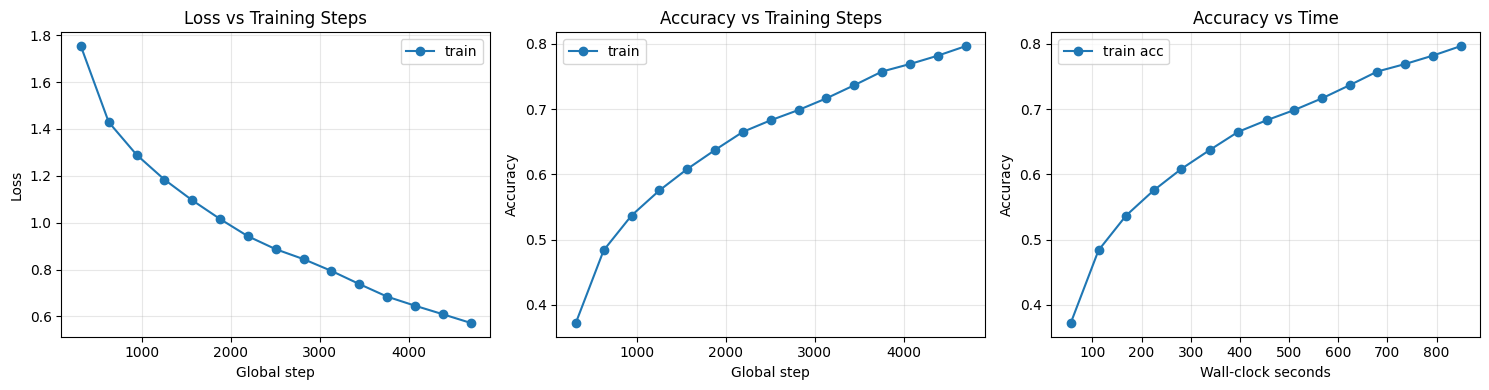

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import math

steps_per_epoch = math.ceil(len(train_loader.dataset) / train_loader.batch_size)
hist_df = pd.DataFrame(history)
hist_df["global_step"] = hist_df["epoch"] * steps_per_epoch
hist_df["cumulative_sec"] = hist_df["duration_sec"].cumsum()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Loss vs Global Step
axes[0].plot(hist_df["global_step"], hist_df["train_loss"], label="train", marker='o')
# axes[0].plot(hist_df["global_step"], hist_df["test_loss"], label="test", marker='s')
axes[0].set_xlabel("Global step")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss vs Training Steps")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Accuracy vs Global Step
axes[1].plot(hist_df["global_step"], hist_df["train_acc"], label="train", marker='o')
# axes[1].plot(hist_df["global_step"], hist_df["test_acc"], label="test", marker='s')
axes[1].set_xlabel("Global step")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Accuracy vs Training Steps")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Accuracy vs Wall-clock Time
axes[2].plot(hist_df["cumulative_sec"], hist_df["train_acc"], label="train acc", marker='o')
# axes[2].plot(hist_df["cumulative_sec"], hist_df["test_acc"], label="test acc", marker='s')
axes[2].set_xlabel("Wall-clock seconds")
axes[2].set_ylabel("Accuracy")
axes[2].set_title("Accuracy vs Time")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# RMSProp

In [68]:
import importlib
import needle.optim as optim

importlib.reload(optim)        # or just restart the kernel
optim.available_optimizers()
importlib.reload(__import__('apps.simple_ml'))

<module 'apps' from '/content/drive/MyDrive/10714/10714-dlsys-final-project-group-43/apps/__init__.py'>

In [69]:
# Place Holder --- Change the config and re-run
use_cuda = True
runtime_device = ndl.cuda() if use_cuda else ndl.cpu()
rmsprop_config = {
    "optimizer": {
        "name": "rmsprop",
        "lr":  1e-3, #0.001
        "weight_decay": 5e-3, #0.005
    },
    "run": {
        "epochs": 15,
        "seed": 42,
        "max_batches": None,  # limit workload for quick tests
        "verbose": True,
        "device": "cuda" if use_cuda else "cpu",
    },
    "loss": {
        "name": "SoftmaxLoss",
    },
    "return_history": True,
    "progress_bar": True,
}

In [72]:
# Initialize tracking lists
rmsprop_history = []
rmspropr_test_metrics = []

In [74]:
# Option 2 (CORRECTED) ------------------------ using log_and_evaluate_epoch with proper train-test split



# Create a fresh model (important: don't reuse a trained model)
model = build_cifar10_model(device=runtime_device)

batch_size = rmsprop_config.get("run", {}).get("batch_size", 128)  # Default 128
# Create train and test loaders with 80-20 split
train_loader, test_loader = build_cifar10_train_test_loaders(
    batch_size=batch_size,
    train_ratio=0.8,  # 80% for training
    seed=42,          # for reproducibility
    device=runtime_device
)

# Verify device setup
params = model.parameters()
if len(params) > 0:
    print(f"Model device: {params[0].device}")
else:
    print("Model has no parameters")
print(f"Runtime device: {runtime_device}")

# Create the callback (using a lambda or partial to capture the lists)
from functools import partial

metrics_callback = partial(
    log_and_evaluate_epoch,
    history=rmsprop_history,
    test_metrics=rmspropr_test_metrics,
    model=model,
    test_loader=test_loader  # Now using the separate test loader
)

# Train with the combined callback
final_acc, final_loss, training_history = train_cifar10(
    model,
    train_loader,  # Training on 80% of data
    optimizer=None,
    loss_fn=nn.SoftmaxLoss,
    config=rmsprop_config,
    metrics_callback=metrics_callback,
)

print("\nFinal training metrics -> Acc: {:.2f}% | Loss: {:.4f}".format(final_acc * 100, final_loss))
# print("Note: Test metrics are evaluated on the held-out 20% test set")

Found CIFAR-10 data at: ./data/cifar-10-batches-py
Loaded full CIFAR-10 dataset with 50000 samples
Split: 40000 train samples, 10000 test samples
Model device: cuda()
Runtime device: cuda()
[Epoch 1/15] starting...


Epoch 1/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 1/15] finished in 56.44s
Epoch 01 done | Train Acc 40.48% | Train Loss 1.6609 | LR 0.001000 | Duration 56.44s
[Epoch 2/15] starting...


Epoch 2/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 2/15] finished in 62.20s
Epoch 02 done | Train Acc 49.33% | Train Loss 1.4036 | LR 0.001000 | Duration 62.20s
[Epoch 3/15] starting...


Epoch 3/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 3/15] finished in 58.18s
Epoch 03 done | Train Acc 53.27% | Train Loss 1.3012 | LR 0.001000 | Duration 58.18s
[Epoch 4/15] starting...


Epoch 4/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 4/15] finished in 59.32s
Epoch 04 done | Train Acc 56.52% | Train Loss 1.2220 | LR 0.001000 | Duration 59.32s
[Epoch 5/15] starting...


Epoch 5/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 5/15] finished in 63.53s
Epoch 05 done | Train Acc 58.95% | Train Loss 1.1585 | LR 0.001000 | Duration 63.53s
[Epoch 6/15] starting...


Epoch 6/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 6/15] finished in 61.81s
Epoch 06 done | Train Acc 61.43% | Train Loss 1.1005 | LR 0.001000 | Duration 61.81s
[Epoch 7/15] starting...


Epoch 7/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 7/15] finished in 61.94s
Epoch 07 done | Train Acc 63.33% | Train Loss 1.0476 | LR 0.001000 | Duration 61.94s
[Epoch 8/15] starting...


Epoch 8/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 8/15] finished in 60.74s
Epoch 08 done | Train Acc 65.11% | Train Loss 1.0029 | LR 0.001000 | Duration 60.74s
[Epoch 9/15] starting...


Epoch 9/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 9/15] finished in 64.16s
Epoch 09 done | Train Acc 66.85% | Train Loss 0.9617 | LR 0.001000 | Duration 64.16s
[Epoch 10/15] starting...


Epoch 10/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 10/15] finished in 63.40s
Epoch 10 done | Train Acc 68.16% | Train Loss 0.9266 | LR 0.001000 | Duration 63.40s
[Epoch 11/15] starting...


Epoch 11/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 11/15] finished in 62.57s
Epoch 11 done | Train Acc 69.17% | Train Loss 0.8977 | LR 0.001000 | Duration 62.57s
[Epoch 12/15] starting...


Epoch 12/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 12/15] finished in 58.23s
Epoch 12 done | Train Acc 70.17% | Train Loss 0.8683 | LR 0.001000 | Duration 58.23s
[Epoch 13/15] starting...


Epoch 13/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 13/15] finished in 59.42s
Epoch 13 done | Train Acc 71.26% | Train Loss 0.8433 | LR 0.001000 | Duration 59.42s
[Epoch 14/15] starting...


Epoch 14/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 14/15] finished in 58.27s
Epoch 14 done | Train Acc 72.17% | Train Loss 0.8190 | LR 0.001000 | Duration 58.27s
[Epoch 15/15] starting...


Epoch 15/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 15/15] finished in 58.56s
Epoch 15 done | Train Acc 72.56% | Train Loss 0.8028 | LR 0.001000 | Duration 58.56s

Final training metrics -> Acc: 72.56% | Loss: 0.8028


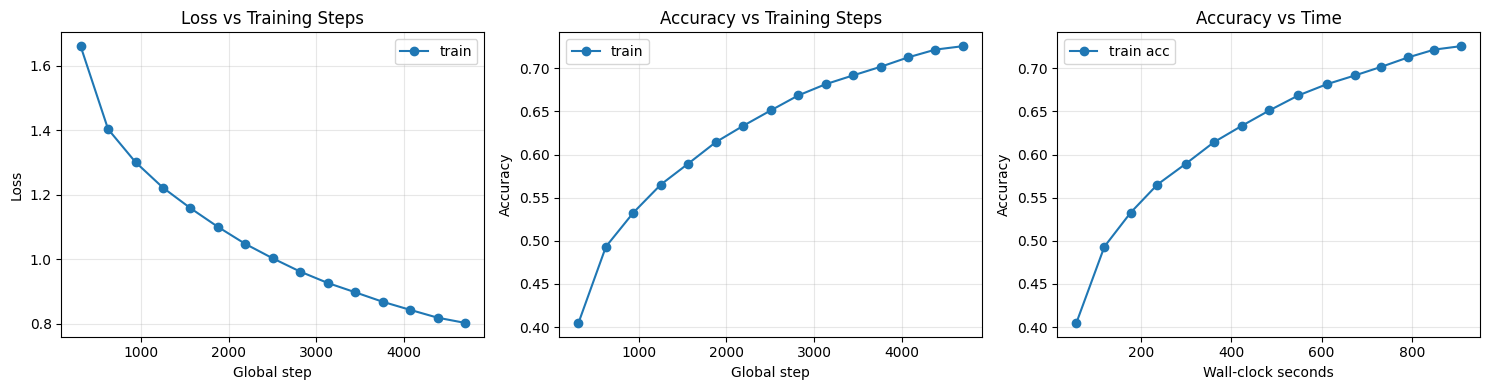

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import math

steps_per_epoch = math.ceil(len(train_loader.dataset) / train_loader.batch_size)
hist_df = pd.DataFrame(rmsprop_history)
hist_df["global_step"] = hist_df["epoch"] * steps_per_epoch
hist_df["cumulative_sec"] = hist_df["duration_sec"].cumsum()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Loss vs Global Step
axes[0].plot(hist_df["global_step"], hist_df["train_loss"], label="train", marker='o')
# axes[0].plot(hist_df["global_step"], hist_df["test_loss"], label="test", marker='s')
axes[0].set_xlabel("Global step")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss vs Training Steps")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Accuracy vs Global Step
axes[1].plot(hist_df["global_step"], hist_df["train_acc"], label="train", marker='o')
# axes[1].plot(hist_df["global_step"], hist_df["test_acc"], label="test", marker='s')
axes[1].set_xlabel("Global step")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Accuracy vs Training Steps")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Accuracy vs Wall-clock Time
axes[2].plot(hist_df["cumulative_sec"], hist_df["train_acc"], label="train acc", marker='o')
# axes[2].plot(hist_df["cumulative_sec"], hist_df["test_acc"], label="test acc", marker='s')
axes[2].set_xlabel("Wall-clock seconds")
axes[2].set_ylabel("Accuracy")
axes[2].set_title("Accuracy vs Time")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Adagrad

In [77]:
import importlib
import needle.optim as optim

importlib.reload(optim)        # or just restart the kernel
optim.available_optimizers()

('adabelief', 'adagrad', 'adam', 'adamw', 'lamb', 'rmsprop', 'sgd')

In [78]:
# Place Holder --- Change the config and re-run
use_cuda = True
runtime_device = ndl.cuda() if use_cuda else ndl.cpu()

adagrad_config = {
    "optimizer": {
        "name": "adagrad",
        "lr":  1e-3, #0.001
        "weight_decay": 5e-3, #0.005
    },
    "run": {
        "epochs": 15,
        "seed": 42,
        "max_batches": None,  # limit workload for quick tests
        "verbose": True,
        "device": "cuda" if use_cuda else "cpu",
    },
    "loss": {
        "name": "SoftmaxLoss",
    },
    "return_history": True,
    "progress_bar": True,
}

In [79]:
# Initialize tracking lists
adagrad_history = []
adagrad_test_metrics = []

In [81]:
# Option 2 (CORRECTED) ------------------------ using log_and_evaluate_epoch with proper train-test split



# Create a fresh model (important: don't reuse a trained model)
model = build_cifar10_model(device=runtime_device)

batch_size = adagrad_config.get("run", {}).get("batch_size", 128)  # Default 128
# Create train and test loaders with 80-20 split
train_loader, test_loader = build_cifar10_train_test_loaders(
    batch_size=batch_size,
    train_ratio=0.8,  # 80% for training
    seed=42,          # for reproducibility
    device=runtime_device
)

# Verify device setup
params = model.parameters()
if len(params) > 0:
    print(f"Model device: {params[0].device}")
else:
    print("Model has no parameters")
print(f"Runtime device: {runtime_device}")

# Create the callback (using a lambda or partial to capture the lists)
from functools import partial

metrics_callback = partial(
    log_and_evaluate_epoch,
    history=adagrad_history,
    test_metrics=adagrad_test_metrics,
    model=model,
    test_loader=test_loader  # Now using the separate test loader
)

# Train with the combined callback
final_acc, final_loss, training_history = train_cifar10(
    model,
    train_loader,  # Training on 80% of data
    optimizer=None,
    loss_fn=nn.SoftmaxLoss,
    config=adagrad_config,
    metrics_callback=metrics_callback,
)

print("\nFinal training metrics -> Acc: {:.2f}% | Loss: {:.4f}".format(final_acc * 100, final_loss))
# print("Note: Test metrics are evaluated on the held-out 20% test set")

Found CIFAR-10 data at: ./data/cifar-10-batches-py
Loaded full CIFAR-10 dataset with 50000 samples
Split: 40000 train samples, 10000 test samples
Model device: cuda()
Runtime device: cuda()
[Epoch 1/15] starting...


Epoch 1/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 1/15] finished in 53.84s
Epoch 01 done | Train Acc 26.38% | Train Loss 2.0390 | LR 0.001000 | Duration 53.84s
[Epoch 2/15] starting...


Epoch 2/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 2/15] finished in 54.35s
Epoch 02 done | Train Acc 34.46% | Train Loss 1.8140 | LR 0.001000 | Duration 54.35s
[Epoch 3/15] starting...


Epoch 3/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 3/15] finished in 53.81s
Epoch 03 done | Train Acc 37.45% | Train Loss 1.7419 | LR 0.001000 | Duration 53.81s
[Epoch 4/15] starting...


Epoch 4/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 4/15] finished in 54.40s
Epoch 04 done | Train Acc 39.41% | Train Loss 1.6957 | LR 0.001000 | Duration 54.40s
[Epoch 5/15] starting...


Epoch 5/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 5/15] finished in 53.78s
Epoch 05 done | Train Acc 40.98% | Train Loss 1.6613 | LR 0.001000 | Duration 53.78s
[Epoch 6/15] starting...


Epoch 6/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 6/15] finished in 53.92s
Epoch 06 done | Train Acc 42.01% | Train Loss 1.6335 | LR 0.001000 | Duration 53.92s
[Epoch 7/15] starting...


Epoch 7/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 7/15] finished in 54.11s
Epoch 07 done | Train Acc 42.94% | Train Loss 1.6103 | LR 0.001000 | Duration 54.11s
[Epoch 8/15] starting...


Epoch 8/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 8/15] finished in 54.16s
Epoch 08 done | Train Acc 43.65% | Train Loss 1.5902 | LR 0.001000 | Duration 54.16s
[Epoch 9/15] starting...


Epoch 9/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 9/15] finished in 53.91s
Epoch 09 done | Train Acc 44.33% | Train Loss 1.5723 | LR 0.001000 | Duration 53.91s
[Epoch 10/15] starting...


Epoch 10/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 10/15] finished in 54.09s
Epoch 10 done | Train Acc 44.92% | Train Loss 1.5562 | LR 0.001000 | Duration 54.09s
[Epoch 11/15] starting...


Epoch 11/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 11/15] finished in 54.28s
Epoch 11 done | Train Acc 45.45% | Train Loss 1.5416 | LR 0.001000 | Duration 54.28s
[Epoch 12/15] starting...


Epoch 12/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 12/15] finished in 54.02s
Epoch 12 done | Train Acc 45.99% | Train Loss 1.5281 | LR 0.001000 | Duration 54.02s
[Epoch 13/15] starting...


Epoch 13/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 13/15] finished in 53.96s
Epoch 13 done | Train Acc 46.56% | Train Loss 1.5156 | LR 0.001000 | Duration 53.96s
[Epoch 14/15] starting...


Epoch 14/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 14/15] finished in 54.53s
Epoch 14 done | Train Acc 47.04% | Train Loss 1.5040 | LR 0.001000 | Duration 54.53s
[Epoch 15/15] starting...


Epoch 15/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 15/15] finished in 54.04s
Epoch 15 done | Train Acc 47.50% | Train Loss 1.4930 | LR 0.001000 | Duration 54.04s

Final training metrics -> Acc: 47.50% | Loss: 1.4930


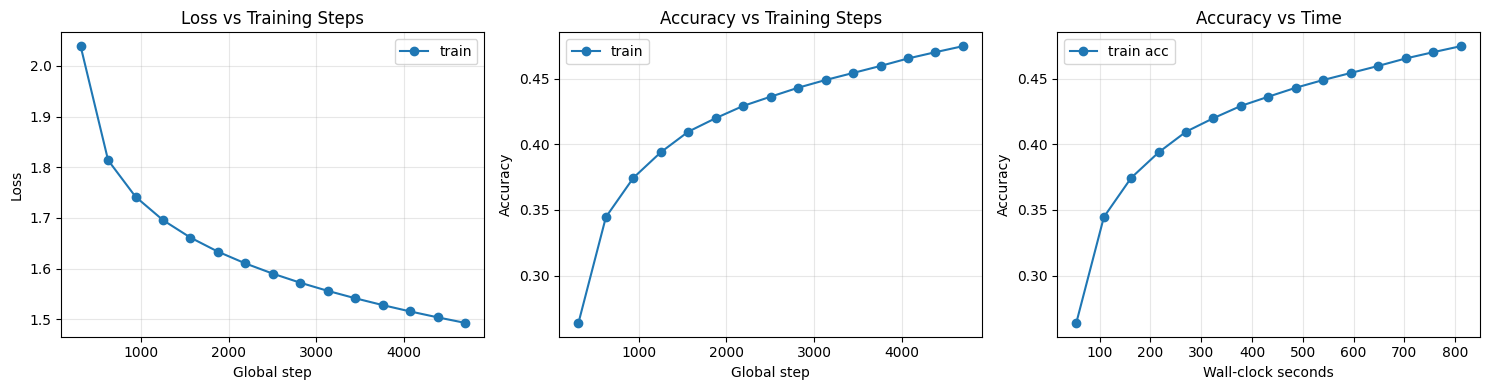

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import math

steps_per_epoch = math.ceil(len(train_loader.dataset) / train_loader.batch_size)
hist_df = pd.DataFrame(adagrad_history)
hist_df["global_step"] = hist_df["epoch"] * steps_per_epoch
hist_df["cumulative_sec"] = hist_df["duration_sec"].cumsum()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Loss vs Global Step
axes[0].plot(hist_df["global_step"], hist_df["train_loss"], label="train", marker='o')
# axes[0].plot(hist_df["global_step"], hist_df["test_loss"], label="test", marker='s')
axes[0].set_xlabel("Global step")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss vs Training Steps")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Accuracy vs Global Step
axes[1].plot(hist_df["global_step"], hist_df["train_acc"], label="train", marker='o')
# axes[1].plot(hist_df["global_step"], hist_df["test_acc"], label="test", marker='s')
axes[1].set_xlabel("Global step")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Accuracy vs Training Steps")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Accuracy vs Wall-clock Time
axes[2].plot(hist_df["cumulative_sec"], hist_df["train_acc"], label="train acc", marker='o')
# axes[2].plot(hist_df["cumulative_sec"], hist_df["test_acc"], label="test acc", marker='s')
axes[2].set_xlabel("Wall-clock seconds")
axes[2].set_ylabel("Accuracy")
axes[2].set_title("Accuracy vs Time")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# LAMB

In [92]:
import importlib
import needle.optim as optim

importlib.reload(optim)        # or just restart the kernel
optim.available_optimizers()

('adabelief', 'adagrad', 'adam', 'adamw', 'lamb', 'rmsprop', 'sgd')

In [93]:
# Place Holder --- Change the config and re-run
use_cuda = True
runtime_device = ndl.cuda() if use_cuda else ndl.cpu()

lamb_config = {
    "optimizer": {
        "name": "lamb",
        "lr":  1e-3, #0.001
        "weight_decay": 5e-3, #0.005
    },
    "run": {
        "epochs": 15,
        "seed": 42,
        "max_batches": None,  # limit workload for quick tests
        "verbose": True,
        "device": "cuda" if use_cuda else "cpu",
    },
    "loss": {
        "name": "SoftmaxLoss",
    },
    "return_history": True,
    "progress_bar": True,
}

In [94]:
# Initialize tracking lists
lamb_history = []
lamb_test_metrics = []

In [95]:
# Option 2 (CORRECTED) ------------------------ using log_and_evaluate_epoch with proper train-test split



# Create a fresh model (important: don't reuse a trained model)
model = build_cifar10_model(device=runtime_device)

batch_size = lamb_config.get("run", {}).get("batch_size", 128)  # Default 128
# Create train and test loaders with 80-20 split
train_loader, test_loader = build_cifar10_train_test_loaders(
    batch_size=batch_size,
    train_ratio=0.8,  # 80% for training
    seed=42,          # for reproducibility
    device=runtime_device
)

# Verify device setup
params = model.parameters()
if len(params) > 0:
    print(f"Model device: {params[0].device}")
else:
    print("Model has no parameters")
print(f"Runtime device: {runtime_device}")

# Create the callback (using a lambda or partial to capture the lists)
from functools import partial

metrics_callback = partial(
    log_and_evaluate_epoch,
    history=lamb_history,
    test_metrics=lamb_test_metrics,
    model=model,
    test_loader=test_loader  # Now using the separate test loader
)

# Train with the combined callback
final_acc, final_loss, training_history = train_cifar10(
    model,
    train_loader,  # Training on 80% of data
    optimizer=None,
    loss_fn=nn.SoftmaxLoss,
    config=lamb_config,
    metrics_callback=metrics_callback,
)

print("\nFinal training metrics -> Acc: {:.2f}% | Loss: {:.4f}".format(final_acc * 100, final_loss))
# print("Note: Test metrics are evaluated on the held-out 20% test set")

Found CIFAR-10 data at: ./data/cifar-10-batches-py
Loaded full CIFAR-10 dataset with 50000 samples
Split: 40000 train samples, 10000 test samples
Model device: cuda()
Runtime device: cuda()
[Epoch 1/15] starting...


Epoch 1/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 1/15] finished in 63.96s
Epoch 01 done | Train Acc 32.52% | Train Loss 1.8797 | LR 0.001000 | Duration 63.96s
[Epoch 2/15] starting...


Epoch 2/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 2/15] finished in 64.10s
Epoch 02 done | Train Acc 44.91% | Train Loss 1.5285 | LR 0.001000 | Duration 64.10s
[Epoch 3/15] starting...


Epoch 3/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 3/15] finished in 63.19s
Epoch 03 done | Train Acc 50.60% | Train Loss 1.3801 | LR 0.001000 | Duration 63.19s
[Epoch 4/15] starting...


Epoch 4/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 4/15] finished in 67.37s
Epoch 04 done | Train Acc 54.78% | Train Loss 1.2703 | LR 0.001000 | Duration 67.37s
[Epoch 5/15] starting...


Epoch 5/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 5/15] finished in 64.61s
Epoch 05 done | Train Acc 58.49% | Train Loss 1.1744 | LR 0.001000 | Duration 64.61s
[Epoch 6/15] starting...


Epoch 6/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 6/15] finished in 65.92s
Epoch 06 done | Train Acc 61.43% | Train Loss 1.0885 | LR 0.001000 | Duration 65.92s
[Epoch 7/15] starting...


Epoch 7/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 7/15] finished in 62.79s
Epoch 07 done | Train Acc 64.46% | Train Loss 1.0043 | LR 0.001000 | Duration 62.79s
[Epoch 8/15] starting...


Epoch 8/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 8/15] finished in 63.03s
Epoch 08 done | Train Acc 67.51% | Train Loss 0.9272 | LR 0.001000 | Duration 63.03s
[Epoch 9/15] starting...


Epoch 9/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 9/15] finished in 62.49s
Epoch 09 done | Train Acc 70.37% | Train Loss 0.8531 | LR 0.001000 | Duration 62.49s
[Epoch 10/15] starting...


Epoch 10/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 10/15] finished in 62.64s
Epoch 10 done | Train Acc 72.92% | Train Loss 0.7852 | LR 0.001000 | Duration 62.64s
[Epoch 11/15] starting...


Epoch 11/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 11/15] finished in 62.92s
Epoch 11 done | Train Acc 75.32% | Train Loss 0.7222 | LR 0.001000 | Duration 62.92s
[Epoch 12/15] starting...


Epoch 12/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 12/15] finished in 62.69s
Epoch 12 done | Train Acc 77.15% | Train Loss 0.6686 | LR 0.001000 | Duration 62.69s
[Epoch 13/15] starting...


Epoch 13/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 13/15] finished in 62.66s
Epoch 13 done | Train Acc 78.55% | Train Loss 0.6230 | LR 0.001000 | Duration 62.66s
[Epoch 14/15] starting...


Epoch 14/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 14/15] finished in 62.25s
Epoch 14 done | Train Acc 79.99% | Train Loss 0.5812 | LR 0.001000 | Duration 62.25s
[Epoch 15/15] starting...


Epoch 15/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 15/15] finished in 62.26s
Epoch 15 done | Train Acc 81.15% | Train Loss 0.5455 | LR 0.001000 | Duration 62.26s

Final training metrics -> Acc: 81.15% | Loss: 0.5455


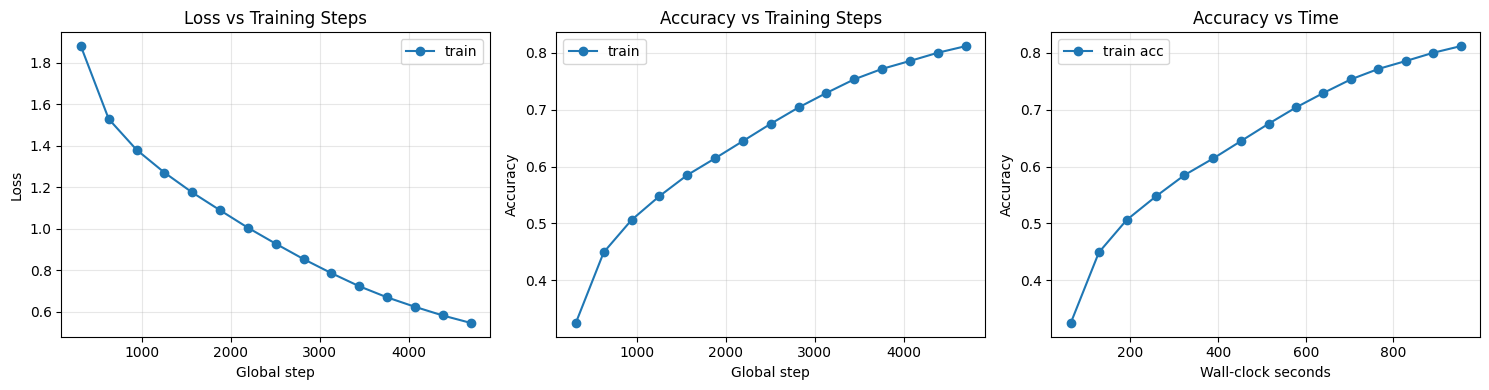

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import math

steps_per_epoch = math.ceil(len(train_loader.dataset) / train_loader.batch_size)
hist_df = pd.DataFrame(lamb_history)
hist_df["global_step"] = hist_df["epoch"] * steps_per_epoch
hist_df["cumulative_sec"] = hist_df["duration_sec"].cumsum()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Loss vs Global Step
axes[0].plot(hist_df["global_step"], hist_df["train_loss"], label="train", marker='o')
# axes[0].plot(hist_df["global_step"], hist_df["test_loss"], label="test", marker='s')
axes[0].set_xlabel("Global step")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss vs Training Steps")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Accuracy vs Global Step
axes[1].plot(hist_df["global_step"], hist_df["train_acc"], label="train", marker='o')
# axes[1].plot(hist_df["global_step"], hist_df["test_acc"], label="test", marker='s')
axes[1].set_xlabel("Global step")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Accuracy vs Training Steps")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Accuracy vs Wall-clock Time
axes[2].plot(hist_df["cumulative_sec"], hist_df["train_acc"], label="train acc", marker='o')
# axes[2].plot(hist_df["cumulative_sec"], hist_df["test_acc"], label="test acc", marker='s')
axes[2].set_xlabel("Wall-clock seconds")
axes[2].set_ylabel("Accuracy")
axes[2].set_title("Accuracy vs Time")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# AdaBelief

In [87]:
import importlib
import needle.optim as optim

importlib.reload(optim)        # or just restart the kernel
optim.available_optimizers()

('adabelief', 'adagrad', 'adam', 'adamw', 'lamb', 'rmsprop', 'sgd')

In [88]:
# Place Holder --- Change the config and re-run
use_cuda = True
runtime_device = ndl.cuda() if use_cuda else ndl.cpu()

adabelief_config = {
    "optimizer": {
        "name": "adabelief",
        "lr":  1e-3, #0.001
        "weight_decay": 5e-3, #0.005
    },
    "run": {
        "epochs": 15,
        "seed": 42,
        "max_batches": None,  # limit workload for quick tests
        "verbose": True,
        "device": "cuda" if use_cuda else "cpu",
    },
    "loss": {
        "name": "SoftmaxLoss",
    },
    "return_history": True,
    "progress_bar": True,
}

In [89]:
# Initialize tracking lists
adabelief_history = []
adabelief_test_metrics = []

In [90]:
# Option 2 (CORRECTED) ------------------------ using log_and_evaluate_epoch with proper train-test split



# Create a fresh model (important: don't reuse a trained model)
model = build_cifar10_model(device=runtime_device)

batch_size = adabelief_config.get("run", {}).get("batch_size", 128)  # Default 128
# Create train and test loaders with 80-20 split
train_loader, test_loader = build_cifar10_train_test_loaders(
    batch_size=batch_size,
    train_ratio=0.8,  # 80% for training
    seed=42,          # for reproducibility
    device=runtime_device
)

# Verify device setup
params = model.parameters()
if len(params) > 0:
    print(f"Model device: {params[0].device}")
else:
    print("Model has no parameters")
print(f"Runtime device: {runtime_device}")

# Create the callback (using a lambda or partial to capture the lists)
from functools import partial

metrics_callback = partial(
    log_and_evaluate_epoch,
    history=adabelief_history,
    test_metrics=adabelief_test_metrics,
    model=model,
    test_loader=test_loader  # Now using the separate test loader
)

# Train with the combined callback
final_acc, final_loss, training_history = train_cifar10(
    model,
    train_loader,  # Training on 80% of data
    optimizer=None,
    loss_fn=nn.SoftmaxLoss,
    config=adabelief_config,
    metrics_callback=metrics_callback,
)

print("\nFinal training metrics -> Acc: {:.2f}% | Loss: {:.4f}".format(final_acc * 100, final_loss))
# print("Note: Test metrics are evaluated on the held-out 20% test set")

Found CIFAR-10 data at: ./data/cifar-10-batches-py
Loaded full CIFAR-10 dataset with 50000 samples
Split: 40000 train samples, 10000 test samples
Model device: cuda()
Runtime device: cuda()
[Epoch 1/15] starting...


Epoch 1/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 1/15] finished in 55.97s
Epoch 01 done | Train Acc 37.65% | Train Loss 1.7394 | LR 0.001000 | Duration 55.97s
[Epoch 2/15] starting...


Epoch 2/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 2/15] finished in 56.63s
Epoch 02 done | Train Acc 48.62% | Train Loss 1.4247 | LR 0.001000 | Duration 56.63s
[Epoch 3/15] starting...


Epoch 3/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 3/15] finished in 56.23s
Epoch 03 done | Train Acc 52.89% | Train Loss 1.3097 | LR 0.001000 | Duration 56.23s
[Epoch 4/15] starting...


Epoch 4/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 4/15] finished in 55.94s
Epoch 04 done | Train Acc 55.98% | Train Loss 1.2312 | LR 0.001000 | Duration 55.94s
[Epoch 5/15] starting...


Epoch 5/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 5/15] finished in 58.05s
Epoch 05 done | Train Acc 58.03% | Train Loss 1.1703 | LR 0.001000 | Duration 58.05s
[Epoch 6/15] starting...


Epoch 6/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 6/15] finished in 60.90s
Epoch 06 done | Train Acc 60.12% | Train Loss 1.1213 | LR 0.001000 | Duration 60.90s
[Epoch 7/15] starting...


Epoch 7/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 7/15] finished in 61.57s
Epoch 07 done | Train Acc 62.04% | Train Loss 1.0743 | LR 0.001000 | Duration 61.57s
[Epoch 8/15] starting...


Epoch 8/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 8/15] finished in 61.89s
Epoch 08 done | Train Acc 63.68% | Train Loss 1.0337 | LR 0.001000 | Duration 61.89s
[Epoch 9/15] starting...


Epoch 9/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 9/15] finished in 61.38s
Epoch 09 done | Train Acc 64.96% | Train Loss 0.9967 | LR 0.001000 | Duration 61.38s
[Epoch 10/15] starting...


Epoch 10/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 10/15] finished in 61.09s
Epoch 10 done | Train Acc 66.21% | Train Loss 0.9629 | LR 0.001000 | Duration 61.09s
[Epoch 11/15] starting...


Epoch 11/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 11/15] finished in 61.15s
Epoch 11 done | Train Acc 67.29% | Train Loss 0.9307 | LR 0.001000 | Duration 61.15s
[Epoch 12/15] starting...


Epoch 12/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 12/15] finished in 61.32s
Epoch 12 done | Train Acc 68.67% | Train Loss 0.9021 | LR 0.001000 | Duration 61.32s
[Epoch 13/15] starting...


Epoch 13/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 13/15] finished in 60.50s
Epoch 13 done | Train Acc 69.76% | Train Loss 0.8730 | LR 0.001000 | Duration 60.50s
[Epoch 14/15] starting...


Epoch 14/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 14/15] finished in 63.99s
Epoch 14 done | Train Acc 70.17% | Train Loss 0.8582 | LR 0.001000 | Duration 63.99s
[Epoch 15/15] starting...


Epoch 15/15:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 15/15] finished in 64.54s
Epoch 15 done | Train Acc 71.45% | Train Loss 0.8311 | LR 0.001000 | Duration 64.54s

Final training metrics -> Acc: 71.45% | Loss: 0.8311


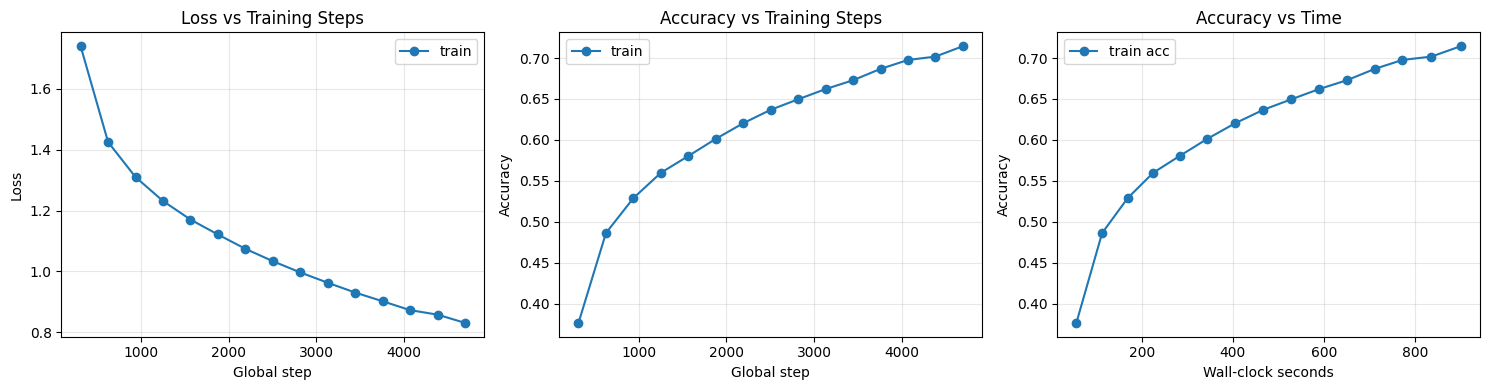

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import math

steps_per_epoch = math.ceil(len(train_loader.dataset) / train_loader.batch_size)
hist_df = pd.DataFrame(adabelief_history)
hist_df["global_step"] = hist_df["epoch"] * steps_per_epoch
hist_df["cumulative_sec"] = hist_df["duration_sec"].cumsum()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Loss vs Global Step
axes[0].plot(hist_df["global_step"], hist_df["train_loss"], label="train", marker='o')
# axes[0].plot(hist_df["global_step"], hist_df["test_loss"], label="test", marker='s')
axes[0].set_xlabel("Global step")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss vs Training Steps")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Accuracy vs Global Step
axes[1].plot(hist_df["global_step"], hist_df["train_acc"], label="train", marker='o')
# axes[1].plot(hist_df["global_step"], hist_df["test_acc"], label="test", marker='s')
axes[1].set_xlabel("Global step")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Accuracy vs Training Steps")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Accuracy vs Wall-clock Time
axes[2].plot(hist_df["cumulative_sec"], hist_df["train_acc"], label="train acc", marker='o')
# axes[2].plot(hist_df["cumulative_sec"], hist_df["test_acc"], label="test acc", marker='s')
axes[2].set_xlabel("Wall-clock seconds")
axes[2].set_ylabel("Accuracy")
axes[2].set_title("Accuracy vs Time")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()




---


# Section 5: Final Thoughts from Above Experiments
Placeholder

In [97]:
adam_history = [
    {'epoch': 1, 'train_acc': 0.3725, 'train_loss': 1.7572, 'learning_rate': 0.001, 'duration_sec': 55.87},
    {'epoch': 2, 'train_acc': 0.4873, 'train_loss': 1.4304, 'learning_rate': 0.001, 'duration_sec': 56.19},
    {'epoch': 3, 'train_acc': 0.5276, 'train_loss': 1.3158, 'learning_rate': 0.001, 'duration_sec': 55.31},
    {'epoch': 4, 'train_acc': 0.5566, 'train_loss': 1.2447, 'learning_rate': 0.001, 'duration_sec': 55.70},
    {'epoch': 5, 'train_acc': 0.5774, 'train_loss': 1.1869, 'learning_rate': 0.001, 'duration_sec': 56.75},
    {'epoch': 6, 'train_acc': 0.5968, 'train_loss': 1.1399, 'learning_rate': 0.001, 'duration_sec': 59.66},
    {'epoch': 7, 'train_acc': 0.6150, 'train_loss': 1.0981, 'learning_rate': 0.001, 'duration_sec': 60.14},
    {'epoch': 8, 'train_acc': 0.6290, 'train_loss': 1.0562, 'learning_rate': 0.001, 'duration_sec': 59.84},
    {'epoch': 9, 'train_acc': 0.6447, 'train_loss': 1.0200, 'learning_rate': 0.001, 'duration_sec': 59.55},
    {'epoch': 10, 'train_acc': 0.6542, 'train_loss': 0.9924, 'learning_rate': 0.001, 'duration_sec': 59.85},
    {'epoch': 11, 'train_acc': 0.6687, 'train_loss': 0.9603, 'learning_rate': 0.001, 'duration_sec': 59.41},
    {'epoch': 12, 'train_acc': 0.6784, 'train_loss': 0.9351, 'learning_rate': 0.001, 'duration_sec': 60.00},
    {'epoch': 13, 'train_acc': 0.6850, 'train_loss': 0.9110, 'learning_rate': 0.001, 'duration_sec': 59.62},
    {'epoch': 14, 'train_acc': 0.6921, 'train_loss': 0.8911, 'learning_rate': 0.001, 'duration_sec': 60.07},
    {'epoch': 15, 'train_acc': 0.7049, 'train_loss': 0.8614, 'learning_rate': 0.001, 'duration_sec': 60.01},
]

In [99]:
rmsprop_history = [
    {'epoch': 1, 'train_acc': 0.4048, 'train_loss': 1.6609, 'learning_rate': 0.001, 'duration_sec': 56.44},
    {'epoch': 2, 'train_acc': 0.4933, 'train_loss': 1.4036, 'learning_rate': 0.001, 'duration_sec': 62.20},
    {'epoch': 3, 'train_acc': 0.5327, 'train_loss': 1.3012, 'learning_rate': 0.001, 'duration_sec': 58.18},
    {'epoch': 4, 'train_acc': 0.5652, 'train_loss': 1.2220, 'learning_rate': 0.001, 'duration_sec': 59.32},
    {'epoch': 5, 'train_acc': 0.5895, 'train_loss': 1.1585, 'learning_rate': 0.001, 'duration_sec': 63.53},
    {'epoch': 6, 'train_acc': 0.6143, 'train_loss': 1.1005, 'learning_rate': 0.001, 'duration_sec': 61.81},
    {'epoch': 7, 'train_acc': 0.6333, 'train_loss': 1.0476, 'learning_rate': 0.001, 'duration_sec': 61.94},
    {'epoch': 8, 'train_acc': 0.6511, 'train_loss': 1.0029, 'learning_rate': 0.001, 'duration_sec': 60.74},
    {'epoch': 9, 'train_acc': 0.6685, 'train_loss': 0.9617, 'learning_rate': 0.001, 'duration_sec': 64.16},
    {'epoch': 10, 'train_acc': 0.6816, 'train_loss': 0.9266, 'learning_rate': 0.001, 'duration_sec': 63.40},
    {'epoch': 11, 'train_acc': 0.6917, 'train_loss': 0.8977, 'learning_rate': 0.001, 'duration_sec': 62.57},
    {'epoch': 12, 'train_acc': 0.7017, 'train_loss': 0.8683, 'learning_rate': 0.001, 'duration_sec': 58.23},
    {'epoch': 13, 'train_acc': 0.7126, 'train_loss': 0.8433, 'learning_rate': 0.001, 'duration_sec': 59.42},
    {'epoch': 14, 'train_acc': 0.7217, 'train_loss': 0.8190, 'learning_rate': 0.001, 'duration_sec': 58.27},
    {'epoch': 15, 'train_acc': 0.7256, 'train_loss': 0.8028, 'learning_rate': 0.001, 'duration_sec': 58.56},
]

In [ ]:
adabelief_history = [
    {'epoch': 1, 'train_acc': 0.3765, 'train_loss': 1.7394, 'learning_rate': 0.001, 'duration_sec': 55.97},
    {'epoch': 2, 'train_acc': 0.4862, 'train_loss': 1.4247, 'learning_rate': 0.001, 'duration_sec': 56.63},
    {'epoch': 3, 'train_acc': 0.5289, 'train_loss': 1.3097, 'learning_rate': 0.001, 'duration_sec': 56.23},
    {'epoch': 4, 'train_acc': 0.5598, 'train_loss': 1.2312, 'learning_rate': 0.001, 'duration_sec': 55.94},
    {'epoch': 5, 'train_acc': 0.5803, 'train_loss': 1.1703, 'learning_rate': 0.001, 'duration_sec': 58.05},
    {'epoch': 6, 'train_acc': 0.6012, 'train_loss': 1.1213, 'learning_rate': 0.001, 'duration_sec': 60.90},
    {'epoch': 7, 'train_acc': 0.6204, 'train_loss': 1.0743, 'learning_rate': 0.001, 'duration_sec': 61.57},
    {'epoch': 8, 'train_acc': 0.6368, 'train_loss': 1.0337, 'learning_rate': 0.001, 'duration_sec': 61.89},
    {'epoch': 9, 'train_acc': 0.6496, 'train_loss': 0.9967, 'learning_rate': 0.001, 'duration_sec': 61.38},
    {'epoch': 10, 'train_acc': 0.6621, 'train_loss': 0.9629, 'learning_rate': 0.001, 'duration_sec': 61.09},
    {'epoch': 11, 'train_acc': 0.6729, 'train_loss': 0.9307, 'learning_rate': 0.001, 'duration_sec': 61.15},
    {'epoch': 12, 'train_acc': 0.6867, 'train_loss': 0.9021, 'learning_rate': 0.001, 'duration_sec': 61.32},
    {'epoch': 13, 'train_acc': 0.6976, 'train_loss': 0.8730, 'learning_rate': 0.001, 'duration_sec': 60.50},
    {'epoch': 14, 'train_acc': 0.7017, 'train_loss': 0.8582, 'learning_rate': 0.001, 'duration_sec': 63.99},
    {'epoch': 15, 'train_acc': 0.7145, 'train_loss': 0.8311, 'learning_rate': 0.001, 'duration_sec': 64.54},
]

In [ ]:
lamb_history = [
    {'epoch': 1, 'train_acc': 0.3252, 'train_loss': 1.8797, 'learning_rate': 0.001, 'duration_sec': 63.96},
    {'epoch': 2, 'train_acc': 0.4491, 'train_loss': 1.5285, 'learning_rate': 0.001, 'duration_sec': 64.10},
    {'epoch': 3, 'train_acc': 0.5060, 'train_loss': 1.3801, 'learning_rate': 0.001, 'duration_sec': 63.19},
    {'epoch': 4, 'train_acc': 0.5478, 'train_loss': 1.2703, 'learning_rate': 0.001, 'duration_sec': 67.37},
    {'epoch': 5, 'train_acc': 0.5849, 'train_loss': 1.1744, 'learning_rate': 0.001, 'duration_sec': 64.61},
    {'epoch': 6, 'train_acc': 0.6143, 'train_loss': 1.0885, 'learning_rate': 0.001, 'duration_sec': 65.92},
    {'epoch': 7, 'train_acc': 0.6446, 'train_loss': 1.0043, 'learning_rate': 0.001, 'duration_sec': 62.79},
    {'epoch': 8, 'train_acc': 0.6751, 'train_loss': 0.9272, 'learning_rate': 0.001, 'duration_sec': 63.03},
    {'epoch': 9, 'train_acc': 0.7037, 'train_loss': 0.8531, 'learning_rate': 0.001, 'duration_sec': 62.49},
    {'epoch': 10, 'train_acc': 0.7292, 'train_loss': 0.7852, 'learning_rate': 0.001, 'duration_sec': 62.64},
    {'epoch': 11, 'train_acc': 0.7532, 'train_loss': 0.7222, 'learning_rate': 0.001, 'duration_sec': 62.92},
    {'epoch': 12, 'train_acc': 0.7715, 'train_loss': 0.6686, 'learning_rate': 0.001, 'duration_sec': 62.69},
    {'epoch': 13, 'train_acc': 0.7855, 'train_loss': 0.6230, 'learning_rate': 0.001, 'duration_sec': 62.66},
    {'epoch': 14, 'train_acc': 0.7999, 'train_loss': 0.5812, 'learning_rate': 0.001, 'duration_sec': 62.25},
    {'epoch': 15, 'train_acc': 0.8115, 'train_loss': 0.5455, 'learning_rate': 0.001, 'duration_sec': 62.26},
]

In [ ]:
adamw_history = [
    {'epoch': 1, 'train_acc': 0.3726, 'train_loss': 1.7532, 'learning_rate': 0.001, 'duration_sec': 56.17},
    {'epoch': 2, 'train_acc': 0.4838, 'train_loss': 1.4290, 'learning_rate': 0.001, 'duration_sec': 56.37},
    {'epoch': 3, 'train_acc': 0.5370, 'train_loss': 1.2898, 'learning_rate': 0.001, 'duration_sec': 56.11},
    {'epoch': 4, 'train_acc': 0.5754, 'train_loss': 1.1840, 'learning_rate': 0.001, 'duration_sec': 55.86},
    {'epoch': 5, 'train_acc': 0.6082, 'train_loss': 1.0956, 'learning_rate': 0.001, 'duration_sec': 56.03},
    {'epoch': 6, 'train_acc': 0.6374, 'train_loss': 1.0157, 'learning_rate': 0.001, 'duration_sec': 58.18},
    {'epoch': 7, 'train_acc': 0.6652, 'train_loss': 0.9422, 'learning_rate': 0.001, 'duration_sec': 57.54},
    {'epoch': 8, 'train_acc': 0.6829, 'train_loss': 0.8869, 'learning_rate': 0.001, 'duration_sec': 57.94},
    {'epoch': 9, 'train_acc': 0.6987, 'train_loss': 0.8444, 'learning_rate': 0.001, 'duration_sec': 56.62},
    {'epoch': 10, 'train_acc': 0.7166, 'train_loss': 0.7943, 'learning_rate': 0.001, 'duration_sec': 56.10},
    {'epoch': 11, 'train_acc': 0.7366, 'train_loss': 0.7383, 'learning_rate': 0.001, 'duration_sec': 56.02},
    {'epoch': 12, 'train_acc': 0.7576, 'train_loss': 0.6846, 'learning_rate': 0.001, 'duration_sec': 56.41},
    {'epoch': 13, 'train_acc': 0.7691, 'train_loss': 0.6459, 'learning_rate': 0.001, 'duration_sec': 56.35},
    {'epoch': 14, 'train_acc': 0.7819, 'train_loss': 0.6095, 'learning_rate': 0.001, 'duration_sec': 56.15},
    {'epoch': 15, 'train_acc': 0.7965, 'train_loss': 0.5725, 'learning_rate': 0.001, 'duration_sec': 56.79},
]

Comparing 6 optimizers: ['Adam', 'AdamW', 'RMSProp', 'Adagrad', 'LAMB', 'AdaBelief']



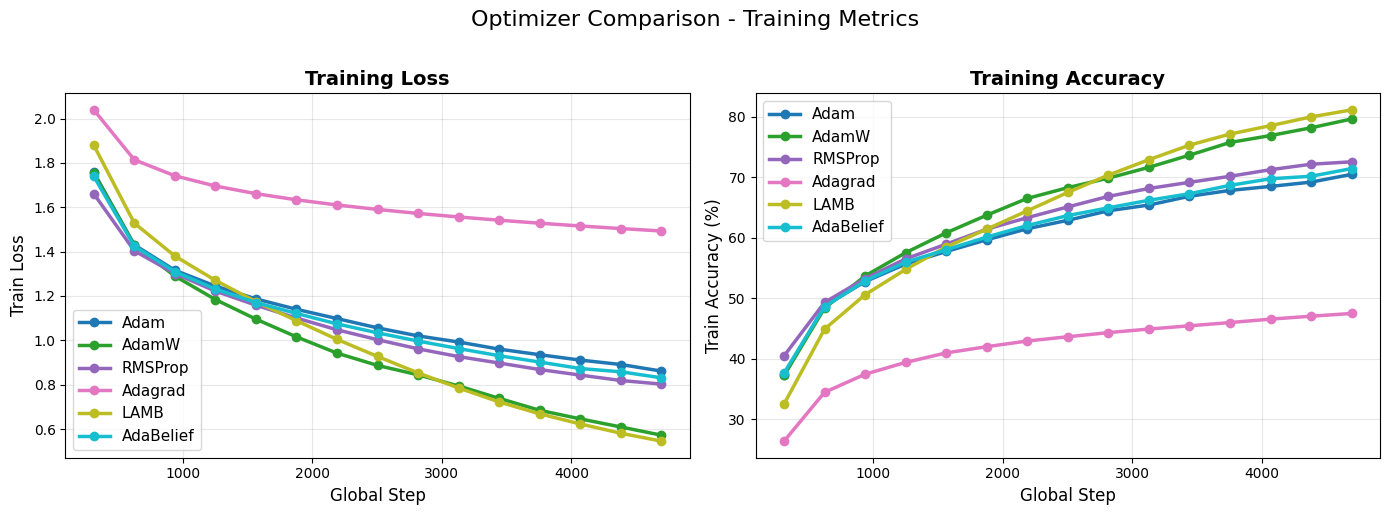


OPTIMIZER COMPARISON SUMMARY
Optimizer Final Train Acc Best Train Acc Final Train Loss Best Train Loss
     Adam          70.49%         70.49%           0.8614          0.8614
    AdamW          79.65%         79.65%           0.5725          0.5725
  RMSProp          72.56%         72.56%           0.8028          0.8028
  Adagrad          47.50%         47.50%           1.4930          1.4930
     LAMB          81.15%         81.15%           0.5455          0.5455
AdaBelief          71.45%         71.45%           0.8311          0.8311


In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

# Dictionary of optimizer histories to compare
# Add your optimizer histories here: optimizer_histories[name] = history
optimizer_histories = {
    'Adam': adam_history if 'adam_history' in locals() else None,
    'AdamW': history if 'history' in locals() else None,
    'RMSProp': rmsprop_history if 'rmsprop_history' in locals() else None,
    'Adagrad': adagrad_history if 'adagrad_history' in locals() else None,
    'LAMB': lamb_history if 'lamb_history' in locals() else None,
    'AdaBelief': adabelief_history if 'adabelief_history' in locals() else None,
}

# Filter out None values (optimizers that haven't been run yet)
optimizer_histories = {k: v for k, v in optimizer_histories.items() if v is not None and len(v) > 0}

if len(optimizer_histories) == 0:
    print("No optimizer histories found!")
    print("Make sure to save histories like: adam_history = history.copy()")
else:
    print(f"Comparing {len(optimizer_histories)} optimizers: {list(optimizer_histories.keys())}\n")

    # Create figure with 2 subplots (Train Loss and Train Accuracy only)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('Optimizer Comparison - Training Metrics', fontsize=16, y=1.02)

    # Color palette
    colors = plt.cm.tab10(np.linspace(0, 1, len(optimizer_histories)))

    # Plot each optimizer
    for idx, (opt_name, history) in enumerate(optimizer_histories.items()):
        color = colors[idx]

        # Convert history to DataFrame
        hist_df = pd.DataFrame(history)

        # Calculate steps
        if 'train_loader' in locals():
            steps_per_epoch = math.ceil(len(train_loader.dataset) / train_loader.batch_size)
        else:
            steps_per_epoch = len(history)  # Fallback

        hist_df["global_step"] = hist_df["epoch"] * steps_per_epoch

        # Plot 1: Train Loss vs Steps
        axes[0].plot(hist_df["global_step"], hist_df["train_loss"],
                     label=opt_name, marker='o', color=color, linewidth=2.5, markersize=6)

        # Plot 2: Train Accuracy vs Steps
        axes[1].plot(hist_df["global_step"], hist_df["train_acc"] * 100,
                     label=opt_name, marker='o', color=color, linewidth=2.5, markersize=6)

    # Configure Plot 1: Train Loss
    axes[0].set_xlabel('Global Step', fontsize=12)
    axes[0].set_ylabel('Train Loss', fontsize=12)
    axes[0].set_title('Training Loss', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)

    # Configure Plot 2: Train Accuracy
    axes[1].set_xlabel('Global Step', fontsize=12)
    axes[1].set_ylabel('Train Accuracy (%)', fontsize=12)
    axes[1].set_title('Training Accuracy', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\n" + "="*70)
    print("OPTIMIZER COMPARISON SUMMARY")
    print("="*70)

    summary_data = []
    for opt_name, history in optimizer_histories.items():
        hist_df = pd.DataFrame(history)

        final_train_acc = hist_df["train_acc"].iloc[-1] * 100
        final_train_loss = hist_df["train_loss"].iloc[-1]
        best_train_acc = hist_df["train_acc"].max() * 100
        best_train_loss = hist_df["train_loss"].min()

        row = {
            'Optimizer': opt_name,
            'Final Train Acc': f'{final_train_acc:.2f}%',
            'Best Train Acc': f'{best_train_acc:.2f}%',
            'Final Train Loss': f'{final_train_loss:.4f}',
            'Best Train Loss': f'{best_train_loss:.4f}',
        }

        summary_data.append(row)

    # Display as DataFrame
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
    print("="*70)




---


# --------- End of Final Project ------------
## ---------- Misc. Experiments --------------
These are experiments that we will leave as placeholders for the purpose of testing. And none of these experiments will contribute to our final report.

Found CIFAR-10 data at: ./data/cifar-10-batches-py
Created DataLoader with 50000 samples, batch_size=128
[Epoch 1/2] starting (128 batches cap)...


Epoch 1/2:   0%|          | 0/128 [00:00<?, ?it/s]

[Epoch 1/2] finished in 388.61s
[Epoch 2/2] starting (128 batches cap)...


Epoch 2/2:   0%|          | 0/128 [00:00<?, ?it/s]

[Epoch 2/2] finished in 387.89s


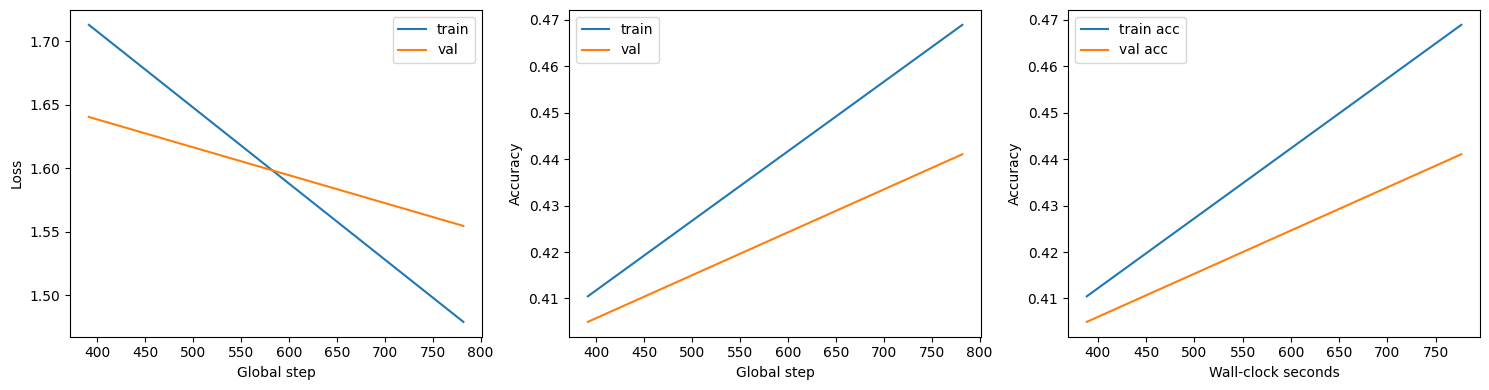

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from apps.simple_ml import evaluate_cifar10
import math

adam_config = {
    "optimizer": {
        "name": "adam",
        "lr": 1e-3,
        "weight_decay": 5e-4,
    },
    "run": {
        "epochs": 2,
        "seed": 42,
        "max_batches": 128,  # limit workload for quick tests
        "verbose": True,
        "device": "cuda" if use_cuda else "cpu",
    },
    "loss": {
        "name": "SoftmaxLoss",
    },
    "return_history": True,
    "progress_bar": True,
}

history = []

val_loader = build_cifar10_train_loader(  # reuse helper but switch to eval data
    batch_size=128,
    shuffle=False,
    device=runtime_device,
)
val_loader.dataset.train = False  # assumes CIFAR10Dataset(train=...) flag

val_metrics = []

def capture_epoch(metrics):
    history.append(metrics)
    val_acc, val_loss = evaluate_cifar10(model, val_loader)
    metrics["val_acc"] = val_acc
    metrics["val_loss"] = val_loss
    val_metrics.append({"epoch": metrics["epoch"], "val_acc": val_acc, "val_loss": val_loss})

final_acc, final_loss, history = train_cifar10(
    model,
    train_loader,
    optimizer=ndl.optim.Adam,
    loss_fn=nn.SoftmaxLoss,
    config=adam_config,
    metrics_callback=capture_epoch,
)

steps_per_epoch = math.ceil(len(train_loader.dataset) / train_loader.batch_size)
hist_df = pd.DataFrame(history)
hist_df["global_step"] = hist_df["epoch"] * steps_per_epoch
hist_df["cumulative_sec"] = hist_df["duration_sec"].cumsum()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].plot(hist_df["global_step"], hist_df["train_loss"], label="train")
axes[0].plot(hist_df["global_step"], hist_df["val_loss"], label="val")
axes[0].set_xlabel("Global step"); axes[0].set_ylabel("Loss"); axes[0].legend()

axes[1].plot(hist_df["global_step"], hist_df["train_acc"], label="train")
axes[1].plot(hist_df["global_step"], hist_df["val_acc"], label="val")
axes[1].set_xlabel("Global step"); axes[1].set_ylabel("Accuracy"); axes[1].legend()

axes[2].plot(hist_df["cumulative_sec"], hist_df["train_acc"], label="train acc")
axes[2].plot(hist_df["cumulative_sec"], hist_df["val_acc"], label="val acc")
axes[2].set_xlabel("Wall-clock seconds"); axes[2].set_ylabel("Accuracy"); axes[2].legend()

plt.tight_layout()

### Hyperparameter Sweep Example
This example shows how to sweep over optimizer settings using the grid utilities. Adjust the sweep specification or builders to match your experiments.


In [ ]:
from apps.simple_ml import run_cifar10_grid_search

print(use_cuda)

# Base configuration shared by all runs
grid_base_config = {
    "optimizer": {
        "name": "adamw",
        "lr": 1e-3,
        "weight_decay": 0.0,
    },
    "run": {
        "epochs": 10,
        "seed": 123,
        "max_batches": 20,  # limit workload for quick tests
        "verbose": True,
        "device": "cuda" if use_cuda else "cpu",
    },
    "loss": {
        "name": "SoftmaxLoss",
    },
    "return_history": True,
    "progress_bar": True,
}

# Sweep specification: try multiple learning rates and beta1 values
grid_sweep_spec = {
    "optimizer.lr": [1e-3, 5e-4],
    "optimizer.hyperparams.beta1": [0.9, 0.95],
}

# Reuse builders from previous cell if available, otherwise define light fallbacks
try:
    build_cifar10_model
    build_cifar10_train_loader
except NameError:
    def build_cifar10_model(device=None, dtype="float32"):
        device = device or ndl.cpu()
        return ResNet9(device=device, dtype=dtype)

    def build_cifar10_train_loader(batch_size=128, shuffle=True):
        dataset = ndl.data.CIFAR10Dataset("data/cifar-10-batches-py", train=True)
        return ndl.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Execute the sweep (each run returns history thanks to merge_run_config)
sweep_results = run_cifar10_grid_search(
    model_builder=lambda: build_cifar10_model(device=ndl.cuda()),
    dataloader_builder=lambda: build_cifar10_train_loader(batch_size=128, shuffle=True, device=ndl.cuda()),
    base_config=grid_base_config,
    sweep_spec=grid_sweep_spec,
)

# Display summary
def summarize_runs(results):
    lines = []
    for result in results:
        cfg = result["config"]
        opt_cfg = cfg.get("optimizer", {})
        lr = opt_cfg.get("lr")
        beta1 = opt_cfg.get("hyperparams", {}).get("beta1")
        final_acc = result["final_acc"] * 100
        final_loss = result["final_loss"]
        lines.append(
            f"Run {result['run_id']:02d}: lr={lr:.5f}, beta1={beta1:.2f} -> Acc {final_acc:.2f}% | Loss {final_loss:.4f}"
        )
    return "\n".join(lines)

print("Adam sweep (learning rate vs beta1):")
print(summarize_runs(sweep_results))


True
Found CIFAR-10 data at: ./data/cifar-10-batches-py
Created DataLoader with 50000 samples, batch_size=128
[Epoch 1/10] starting (20 batches cap)...


Epoch 1/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 1/10] finished in 3.63s
[Epoch 2/10] starting (20 batches cap)...


Epoch 2/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 2/10] finished in 3.52s
[Epoch 3/10] starting (20 batches cap)...


Epoch 3/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 3/10] finished in 3.58s
[Epoch 4/10] starting (20 batches cap)...


Epoch 4/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 4/10] finished in 4.13s
[Epoch 5/10] starting (20 batches cap)...


Epoch 5/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 5/10] finished in 3.43s
[Epoch 6/10] starting (20 batches cap)...


Epoch 6/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 6/10] finished in 3.55s
[Epoch 7/10] starting (20 batches cap)...


Epoch 7/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 7/10] finished in 3.85s
[Epoch 8/10] starting (20 batches cap)...


Epoch 8/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 8/10] finished in 3.68s
[Epoch 9/10] starting (20 batches cap)...


Epoch 9/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 9/10] finished in 3.54s
[Epoch 10/10] starting (20 batches cap)...


Epoch 10/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 10/10] finished in 3.55s
Found CIFAR-10 data at: ./data/cifar-10-batches-py
Created DataLoader with 50000 samples, batch_size=128
[Epoch 1/10] starting (20 batches cap)...


Epoch 1/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 1/10] finished in 3.90s
[Epoch 2/10] starting (20 batches cap)...


Epoch 2/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 2/10] finished in 3.58s
[Epoch 3/10] starting (20 batches cap)...


Epoch 3/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 3/10] finished in 3.54s
[Epoch 4/10] starting (20 batches cap)...


Epoch 4/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 4/10] finished in 4.44s
[Epoch 5/10] starting (20 batches cap)...


Epoch 5/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 5/10] finished in 3.72s
[Epoch 6/10] starting (20 batches cap)...


Epoch 6/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 6/10] finished in 3.54s
[Epoch 7/10] starting (20 batches cap)...


Epoch 7/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 7/10] finished in 3.61s
[Epoch 8/10] starting (20 batches cap)...


Epoch 8/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 8/10] finished in 3.89s
[Epoch 9/10] starting (20 batches cap)...


Epoch 9/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 9/10] finished in 3.61s
[Epoch 10/10] starting (20 batches cap)...


Epoch 10/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 10/10] finished in 3.57s
Found CIFAR-10 data at: ./data/cifar-10-batches-py
Created DataLoader with 50000 samples, batch_size=128
[Epoch 1/10] starting (20 batches cap)...


Epoch 1/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 1/10] finished in 3.64s
[Epoch 2/10] starting (20 batches cap)...


Epoch 2/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 2/10] finished in 3.95s
[Epoch 3/10] starting (20 batches cap)...


Epoch 3/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 3/10] finished in 3.69s
[Epoch 4/10] starting (20 batches cap)...


Epoch 4/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 4/10] finished in 3.49s
[Epoch 5/10] starting (20 batches cap)...


Epoch 5/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 5/10] finished in 4.08s
[Epoch 6/10] starting (20 batches cap)...


Epoch 6/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 6/10] finished in 3.67s
[Epoch 7/10] starting (20 batches cap)...


Epoch 7/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 7/10] finished in 3.47s
[Epoch 8/10] starting (20 batches cap)...


Epoch 8/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 8/10] finished in 3.71s
[Epoch 9/10] starting (20 batches cap)...


Epoch 9/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 9/10] finished in 4.00s
[Epoch 10/10] starting (20 batches cap)...


Epoch 10/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 10/10] finished in 3.43s
Found CIFAR-10 data at: ./data/cifar-10-batches-py
Created DataLoader with 50000 samples, batch_size=128
[Epoch 1/10] starting (20 batches cap)...


Epoch 1/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 1/10] finished in 3.61s
[Epoch 2/10] starting (20 batches cap)...


Epoch 2/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 2/10] finished in 4.00s
[Epoch 3/10] starting (20 batches cap)...


Epoch 3/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 3/10] finished in 3.57s
[Epoch 4/10] starting (20 batches cap)...


Epoch 4/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 4/10] finished in 3.55s
[Epoch 5/10] starting (20 batches cap)...


Epoch 5/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 5/10] finished in 3.65s
[Epoch 6/10] starting (20 batches cap)...


Epoch 6/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 6/10] finished in 4.03s
[Epoch 7/10] starting (20 batches cap)...


Epoch 7/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 7/10] finished in 3.57s
[Epoch 8/10] starting (20 batches cap)...


Epoch 8/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 8/10] finished in 3.55s
[Epoch 9/10] starting (20 batches cap)...


Epoch 9/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 9/10] finished in 4.10s
[Epoch 10/10] starting (20 batches cap)...


Epoch 10/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 10/10] finished in 3.82s
Adam sweep (learning rate vs beta1):
Run 01: lr=0.00100, beta1=0.90 -> Acc 99.34% | Loss 0.0807
Run 02: lr=0.00100, beta1=0.95 -> Acc 99.80% | Loss 0.0541
Run 03: lr=0.00050, beta1=0.90 -> Acc 98.91% | Loss 0.2000
Run 04: lr=0.00050, beta1=0.95 -> Acc 99.22% | Loss 0.2057


In [ ]:
import sys
sys.path.append('./python')
sys.path.append('./apps')
import needle as ndl
from models import ResNet9
from simple_ml import train_cifar10, evaluate_cifar10
def to_device(loader, device):
      for X, y in loader:
          yield (
              ndl.Tensor(X.numpy(), device=device),
              ndl.Tensor(y.numpy(), device=device),
          )
device = ndl.cuda()
if not device.enabled():
    device = ndl.cpu()
dataset = ndl.data.CIFAR10Dataset("data/cifar-10-batches-py", train=True)
base_loader = ndl.data.DataLoader(dataset=dataset, batch_size=128, shuffle=True)

train_loader = to_device(base_loader, device)

model = ResNet9(device=device, dtype="float32")
train_cifar10(model, train_loader, n_epochs=10, optimizer=ndl.optim.Adam, lr=0.001, weight_decay=0.001)
# dataset = ndl.data.CIFAR10Dataset("data/cifar-10-batches-py", train=True)
# dataloader = ndl.data.DataLoader(\
#          dataset=dataset,
#          batch_size=128,
#          shuffle=True,)
# model = ResNet9(device=device, dtype="float32")
# train_cifar10(model, dataloader, n_epochs=10, optimizer=ndl.optim.Adam,
#       lr=0.001, weight_decay=0.001)
evaluate_cifar10(model, base_loader)

TypeError: matmul(): incompatible function arguments. The following argument types are supported:
    1. (arg0: needle.backend_ndarray.ndarray_backend_cuda.Array, arg1: needle.backend_ndarray.ndarray_backend_cuda.Array, arg2: needle.backend_ndarray.ndarray_backend_cuda.Array, arg3: typing.SupportsInt, arg4: typing.SupportsInt, arg5: typing.SupportsInt) -> None

Invoked with: <needle.backend_ndarray.ndarray_backend_cuda.Array object at 0x7e90c90da730>, <needle.backend_ndarray.ndarray_backend_cpu.Array object at 0x7e90c81697b0>, <needle.backend_ndarray.ndarray_backend_cuda.Array object at 0x7e90c8723c30>, 8192, 147, 16